In [1]:
import matplotlib.pyplot as plt
from numpy.polynomial import Polynomial as P
import pandas as pd
from pathlib import Path
import statsmodels.api as sm
import statsmodels.formula.api as smf


def load_google_trends(search_term):
    file_path = Path(f'data/search-index-{search_term}.txt')
    return pd.read_csv(file_path, index_col='week', squeeze=True, parse_dates=True)


class time_series_helper():
    def __init__(self):
        self.observed = None
        self.method = None
        self.window = None
        self.period = None
        self.fitted = None
        self.label = None
        self.resid = None
     
    def fit(self, series, method='data', deg=1, window=6, period='month'):
        self.observed = series
        self.method = method
        self.window = window
        self.period = period
            
        if method == 'data':
            self.fitted = self.observed
            self.label = 'data'
        
        # Fit a polynomial to a time series.
        elif method == 'linear':
            # Construct design matrix from a series by adding intercept column.
            X = np.arange(len(series))
            y = series
            p = P.fit(X, y, deg)
            coef = p.convert().coef
            ffit = P(coef)

            self.fitted = pd.Series(ffit(X), index=series.index)
            self.label = f'linear trend \ndegree={deg}'
        
            
        elif method == 'moving average':
            self.fitted = series.rolling(window=window, center=True).mean()
            self.label = f'moving average trend \n(window={window})'

        elif method == 'seasonality':
            if period == 'week':
                period_feature = series.index.isocalendar().week.astype(np.int64)
            elif period == 'month':
                period_feature = series.index.month
            else:
                print("Valid periods are 'week' and 'month'.")
                
            df = pd.DataFrame({f'{series.name}': series, f'{period}': period_feature})
            res = smf.ols(f'{series.name} ~ C({period})', df).fit()
            
            self.fitted = pd.Series(res.predict(df), index=series.index)
            self.label = f'seasonality \n(period={period})'
        
        else:
            print("Valid methods are 'data', 'linear', 'moving average', and 'seasonality'.")            
        
        self.resid = self.observed - self.fitted
        return self
    
    def plot(self, ax, kind='predict', legend=False, *args, **kwargs):
        if kind == 'predict':
            ax.plot(self.observed, ls='dotted', marker='.')
            ax.plot(self.fitted, label=self.label, ls='dotted', marker='.')
        
        elif kind == 'resid':
            ax.plot(self.resid, ls='dotted', marker='.')
        else:
            print("Valid kinds are 'predict' and 'resid'.")
            
        ax.set(*args, **kwargs)
        if legend:
            ax.legend(loc='upper left')
            
    def diag(self):
        print(
            f'observed: {self.observed}',
            f'method: {self.method}',
            f'period: {self.period}',
            f'window: {self.window}',
            f'label: {self.label}',
            f'fitted: {self.fitted}',
            f'resid: {self.resid}',
            sep='\n'
        )
         
            
def time_series_plotter(plot_obj, figsize=(6.4 * 2, 4.8 / 2), suptitle='', *args, **kwargs):
    fig, ax = plt.subplots(figsize=figsize)
    fig.suptitle(suptitle, size='xx-large')
    plot_obj(ax, *args, **kwargs)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    
def ylim_rescale(series, halfrange, margin=5):
    mid = (series.max() + series.min()) / 2
    return mid - halfrange - margin, mid + halfrange + margin


def plot_seasonal_decompose(series, classic=True, test=False, y_margin=0, 
                            series_label='Relative Search \nInterest', *args, **kwargs):
    if classic:
        res = sm.tsa.seasonal_decompose(series, *args, **kwargs)
    else:
        res = sm.tsa.STL(series, *args, **kwargs).fit()
        
    components = [res.observed, res.trend, res.seasonal, res.resid]
    
    titles = [''] * 4
    if test:
        test = sm.tsa.stattools.kpss(res.resid.dropna(), nlags='auto')
        titles[-1] = f'Residual (KPSS p-value: {test[1]:.3f})'
        
    ylabels = [series_label, 'Trend', 'Seasonal', 'Residual']
    y_halfrange = max([(component.max() - component.min()) / 2 for component in components]) + y_margin
    ylims = [ylim_rescale(component, y_halfrange, margin=y_margin) for component in components]
    
    fig, axs = plt.subplots(4, figsize=(6.4 * 2, 4.8 / 2 * 3), sharex=True)
    fig.suptitle(f'{series.name} Decomposition', size='x-large')

    for ax, component, title, ylabel, ylim in zip(axs, components, titles, ylabels, ylims):
        component.plot(ax=ax, ls='dotted', marker='.')
        ax.set(title=title, ylabel=ylabel, ylim=ylim)

    fig.tight_layout(rect=[0, 0, 1, 0.95])

    plt.show()
    
    
def plot_series_and_difference(series, order=1, test=False):
    name = series.name
    if test:
        test = sm.tsa.stattools.kpss(series, nlags='auto')
        title = f'{name} (KPSS p-value: {test[1]:.3f})'
    else:
        title = f'{name}'
    time_series_plotter(helper.fit(series).plot, title=title)

    for i in range(order):
        series = series.diff().dropna()
        if test:
            test = sm.tsa.stattools.kpss(series, nlags='auto')
            title = f'{name}, Difference({i + 1}) (KPSS p-value: {test[1]:.3f})'
        else:
            title = f'{name}, Difference({i + 1})'
        time_series_plotter(helper.fit(series).plot, title=title, ylabel='Difference')

    
def gaussian_white_noise(size=250):
    return pd.Series(np.random.normal(size=size), name='gaussian white noise')


def random_walk(size=250):
    return pd.Series(np.cumsum(gaussian_white_noise(size=size)), name='random walk')

def ma(coef, size=250):
    return pd.Series(np.convolve(gaussian_white_noise(size=size), coef, mode='valid'), name='MA')

In [2]:
import itertools
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy import signal, stats
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX

plt.style.use('ggplot')

# Time Series


## Objectives

By the end of the day you should be able to:

  - Define **time series**.
  - Define **trend** in a time series. What does it mean to **detrend** a time series?
  - Define **seasonality** in a time series. What does it mean to **seasonally adjust** a time series?
  - Define **autocorrelation** in a time series.
  - Use the classical decomposition to decompose a time series.
  - Define **stationarity** and contrast it with independence.
  - Identify a stationary time series.
  - Fit ARIMA models to forecast a stationary time series.

# Morning Lecture
## Fundamental Concepts

A **time series** is a series of data points where a single quantity is measured over time.

We will represent the time series mathematically with a time index $t$ and the observations from the series as $y_{t}$.

$$y_{1}, y_{2}, y_{3}, \ldots y_{n}$$

Analyzing a time series is difficult because each data point is often a function of previous data points. This violates one assumption of linear regression: that the observations aren't correlated with each other.

How is time series regression different from other regressions we have learned so far? In other regressions we **interpolate** within the range of our training data. In time series regression we **extrapolate** outside the range of our training data. 

We also validate a time series model differently than other models.

In [3]:
helper = time_series_helper() # instantiate our helper object

In [4]:
weather = pd.read_csv('data/weather_data.csv', index_col=0, parse_dates=True)
series = weather.MaxTemp
params = {'title':'Weather', 'ylabel':f'{series.name} ($^\circ$C)'}

time_series_plotter(helper.fit(series).plot, **params)

FileNotFoundError: [Errno 2] File data/weather_data.csv does not exist: 'data/weather_data.csv'

A source of time series data is [Google Trends](https://www.google.com/trends/), where you can see how the popularity of different search terms varies over time.

Google Trends data for some search terms are in the `data` directory.

In [5]:
google_search_terms = ['baseball', 'python', 'gmail', 'pokemon', 'taxes', 'gdp', 'blackberry', 'data-science']
google_trends = {search_term: load_google_trends(search_term) for search_term in google_search_terms}

data_label = 'Relative Search \nInterest'
resid_params = {'ylabel':'Residual', 'kind':'resid'}

## Trend

A **trend** in a time series is a gradual change in average level with time. A trend can be *increasing*, *decreasing*, or *neither* (i.e. a trend that changes direction.) 

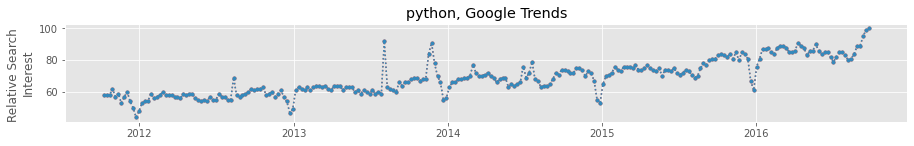

In [6]:
search_term = 'python'
time_series_plotter(helper.fit(google_trends[search_term]).plot, title=f'{search_term}, Google Trends', ylabel=data_label)

Search interest for **python** shows an increasing trend.

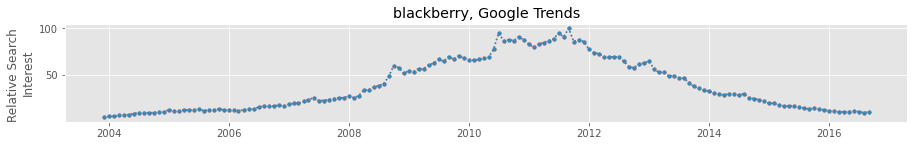

In [7]:
search_term = 'blackberry'
time_series_plotter(helper.fit(google_trends[search_term]).plot, title=f'{search_term}, Google Trends', ylabel=data_label)

Search interest for **blackberry** shows a nonlinear trend. It increases to a peak popularity then decreases to almost nothing.

## Seasonality

**Seasonality** is a pattern in a time series that appears at regular intervals that conform to the calendar year (weekly, monthly, quarterly, etc.)

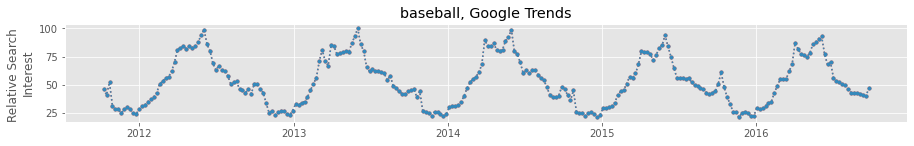

In [8]:
search_term = 'baseball'
time_series_plotter(helper.fit(google_trends[search_term]).plot, title=f'{search_term}, Google Trends', ylabel=data_label)

Every year, search interest for **baseball** increases until the baseball season starts and then decreases as the season progresses.

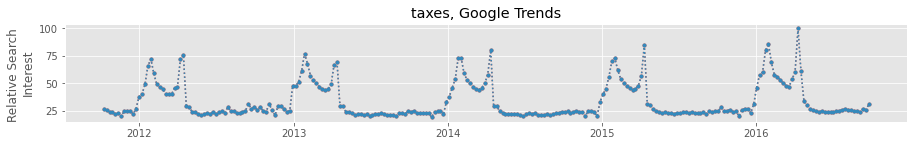

In [9]:
search_term = 'taxes'
time_series_plotter(helper.fit(google_trends[search_term]).plot, title=f'{search_term}, Google Trends', ylabel=data_label)

Search interest for **taxes** spikes regularly two times a year, with interest being heightened between those two dates. Search interest is low for the rest of the year.

## Cyclical Patterns

**Cyclical** patterns in a time series rise and fall according to irregular periods.

## Autocorrelation

In a time series, an observation at one point in time is often influenced by the previous observations. This pattern of association is called **autocorrelation**. When a time series exhibits **positive autocorrelation** its level appears *sticky*.

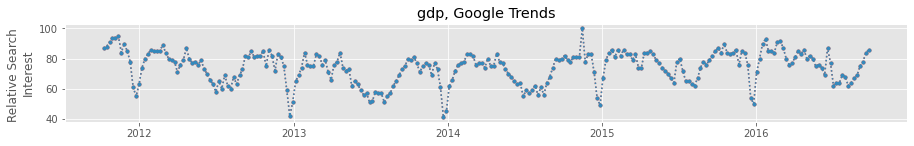

In [10]:
search_term = 'gdp'
time_series_plotter(helper.fit(google_trends[search_term]).plot, title=f'{search_term}, Google Trends', ylabel=data_label)

Search interest for **gdp** shows *stickiness*. Low search interest begets low subsequent interest and high interest begets high subsequent interest.

**Activity:** Load and plot the trend data for `data-science`, what patterns do you see?

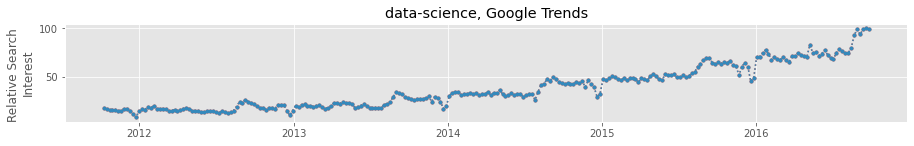

In [11]:
search_term = 'data-science'
time_series_plotter(helper.fit(google_trends[search_term]).plot, title=f'{search_term}, Google Trends', ylabel=data_label)

## Modeling Trend

Let's fit a simple linear regression model to the python search data and use its predictions on the training data to capture the trend.

The correlation between time series values makes standard hypothesis tests unreliable, but does not affect the accuracy/unbiasedness of the prediction.

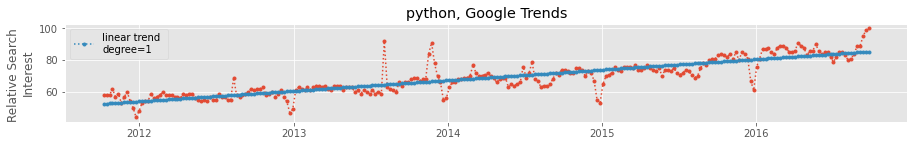

In [12]:
search_term = 'python'
time_series_plotter(helper.fit(google_trends[search_term], method='linear').plot, 
        title=f'{search_term}, Google Trends', legend=True, ylabel=data_label)

We get the **detrended series** by subtracting the fit trend from the original series. 

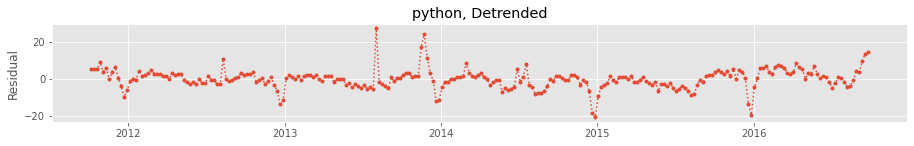

In [13]:
search_term = 'python'
time_series_plotter(helper.fit(google_trends[search_term], method='linear').plot, 
        title=f'{search_term}, Detrended', **resid_params)

Detrending is often the first step in analyzing a time series.

In the following cases, fitting a line is inappropriate, so we might try higher order polynomials.

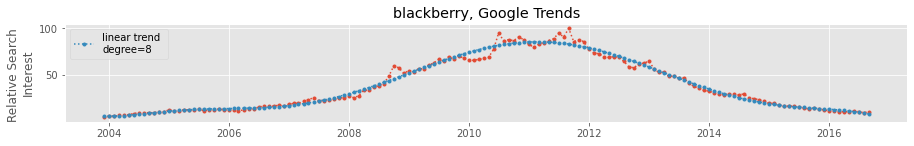

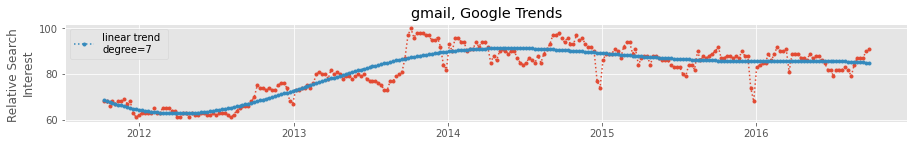

In [14]:
search_term = 'blackberry'
time_series_plotter(helper.fit(google_trends[search_term], method='linear', deg=8).plot, 
        title=f'{search_term}, Google Trends', legend=True, ylabel=data_label)

search_term = 'gmail'
time_series_plotter(helper.fit(google_trends[search_term], method='linear', deg=7).plot, 
        title=f'{search_term}, Google Trends', legend=True, ylabel=data_label)

A more common and flexible method for modeling the trend is the **moving average**.

The moving average estimate of the trend at a data point $y_t$ is

$$ \hat y_t = \frac{1}{w} \sum_{i = \left \lfloor{-\frac{w-1}{2}}\right \rfloor}^{\left \lfloor{\frac{w-1}{2}}\right \rfloor} y_{t + i} $$

We slide a **window** of fixed size $w$ across our data and average the values within the window.

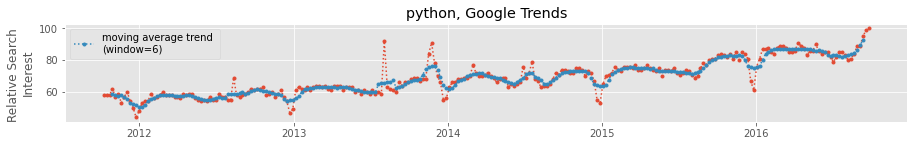

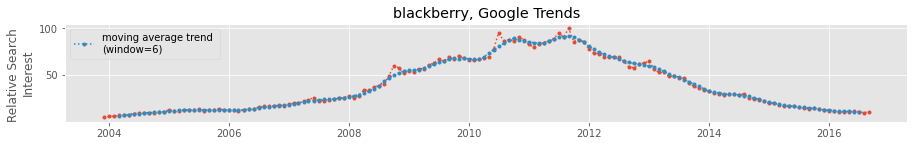

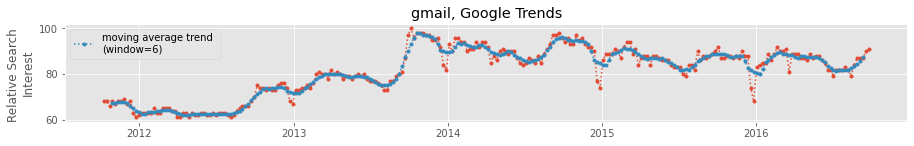

In [15]:
for search_term in ['python', 'blackberry', 'gmail']:
    time_series_plotter(helper.fit(google_trends[search_term], method='moving average').plot, 
            title=f'{search_term}, Google Trends', legend=True, ylabel=data_label)

Varying the window parameter changes the amount of smoothing applied to short-term fluctuations.

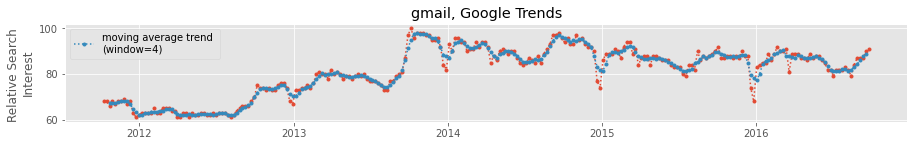

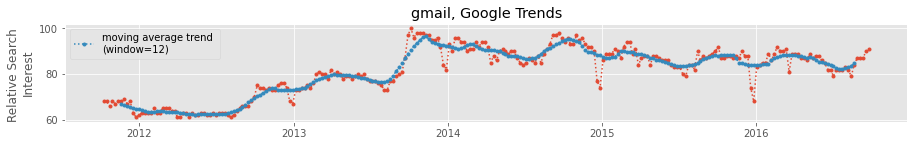

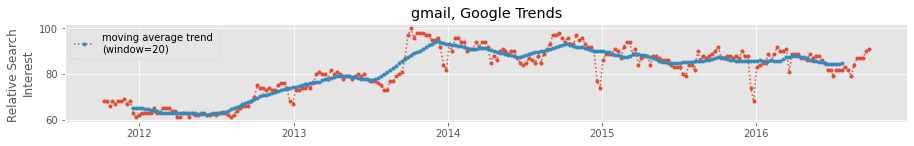

In [16]:
search_term = 'gmail'
for window in range(4, 20 + 1, 8):
    time_series_plotter(helper.fit(google_trends[search_term], method='moving average', window=window).plot,
            title=f'{search_term}, Google Trends', legend=True, ylabel=data_label)

We see that:

  - Smaller values of `window` will fit to non-trend patterns (potentially noise) in the series.
  - Larger values of `window` produce smoother estimates of the general trend in the data.
  
We prefer larger windows when estimating the trend component of a time series.

**Activity:** Fit a moving average smoother to the `data-science` series of various windows and plot the results.

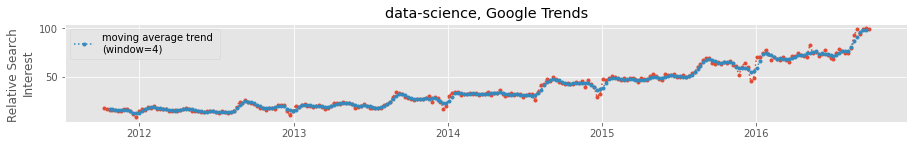

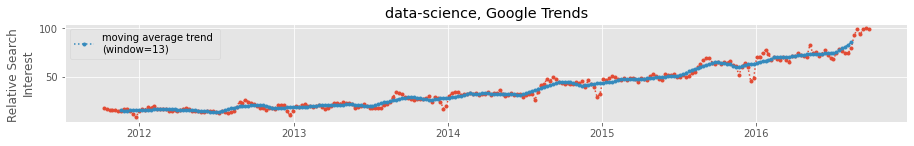

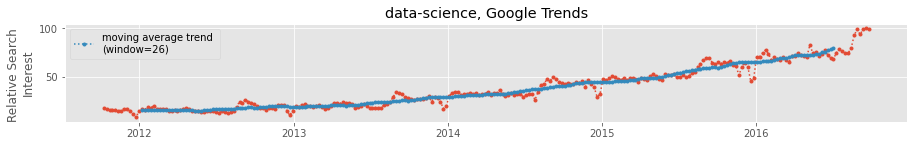

In [17]:
search_term = 'data-science'
for window in [4, 13, 26]:
    time_series_plotter(helper.fit(google_trends[search_term], method='moving average', window=window).plot,
            title=f'{search_term}, Google Trends', legend=True, ylabel=data_label)

When we have data with observations at regular calendar intervals (weekly, quarterly, yearly, etc.) we should set the window for the moving average smoother to span an entire annual period to average out any seasonal patterns and resolve the trend.

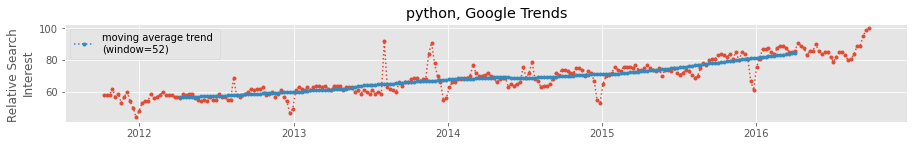

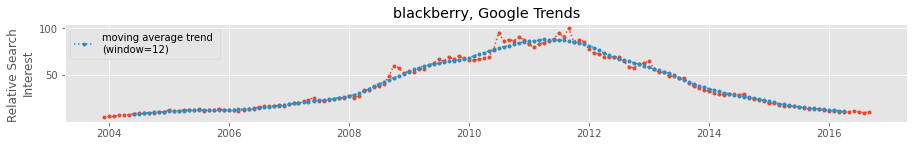

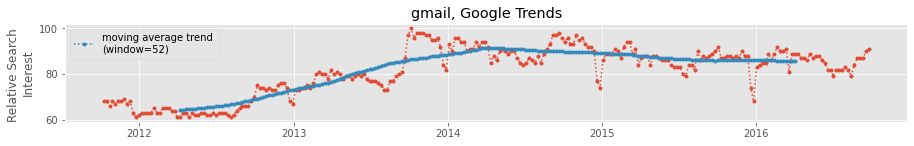

In [18]:
search_terms = ['python', 'blackberry', 'gmail']
windows = [52, 12, 52]
for search_term, window in zip(search_terms, windows):
    time_series_plotter(helper.fit(google_trends[search_term], method='moving average', window=window).plot,
            title=f'{search_term}, Google Trends', legend=True, ylabel=data_label)

## Modeling Seasonality

A simple method to fit seasonality in a time series is to create dummy variables at regular calendar intervals
  - e.g. a dummy for each month or a dummy for each week.
  
and then fit a linear regression to the series using these dummy variables as predictors.

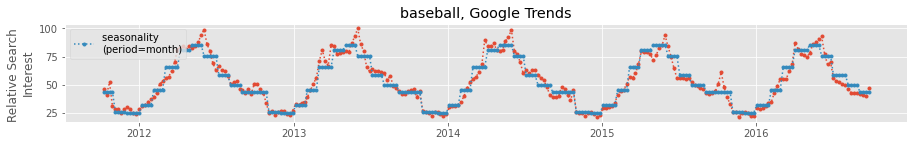

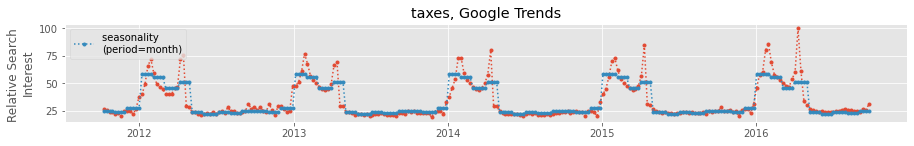

In [19]:
for search_term in ['baseball', 'taxes']:
    time_series_plotter(helper.fit(google_trends[search_term], method='seasonality').plot, 
            title=f'{search_term}, Google Trends', legend=True, ylabel=data_label)

Just like we can **detrend** a time series, we can also **deseasonalize or seasonally adjust** a time series.

We subtract the seasonal trend to seasonally adjust a time series.

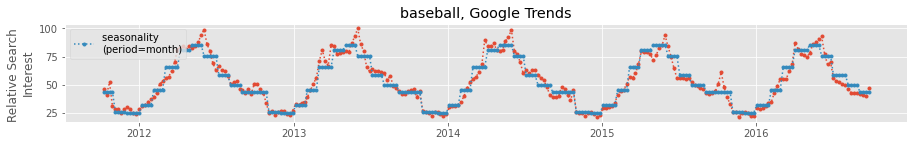

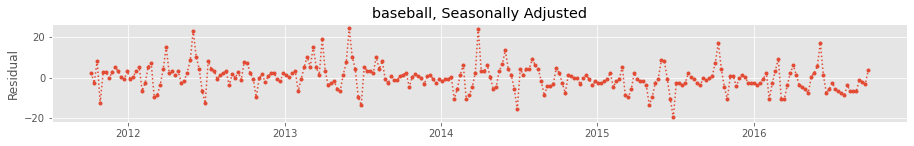

In [20]:
search_term = 'baseball'
seasonal_fit = helper.fit(google_trends[search_term], method='seasonality')

time_series_plotter(seasonal_fit.plot,
        title=f'{search_term}, Google Trends', legend=True, ylabel=data_label)
time_series_plotter(seasonal_fit.plot, 
        title=f'{search_term}, Seasonally Adjusted', **resid_params)

**Activity:** Seasonally adjust the `taxes` series.

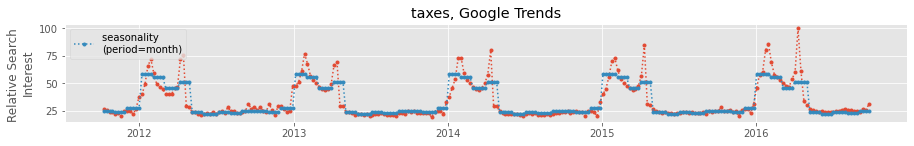

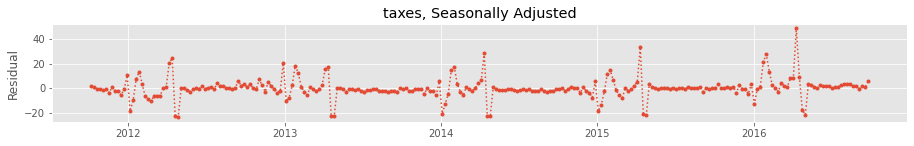

In [21]:
search_term = 'taxes'
seasonal_fit = helper.fit(google_trends[search_term], method='seasonality')

time_series_plotter(seasonal_fit.plot,
        title=f'{search_term}, Google Trends', legend=True, ylabel=data_label)
time_series_plotter(seasonal_fit.plot, 
        title=f'{search_term}, Seasonally Adjusted', **resid_params)

**Question:** Have we removed the seasonality from these series?  What more could we do?

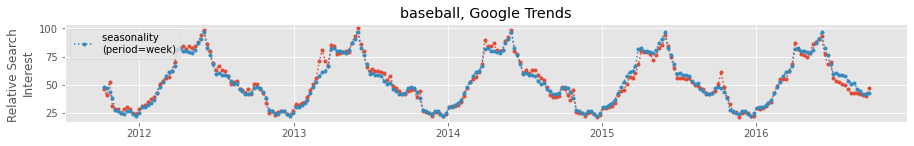

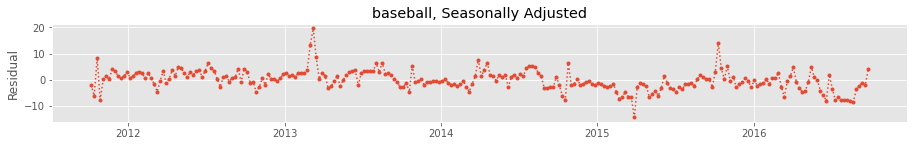

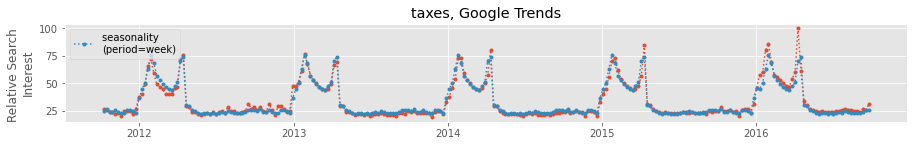

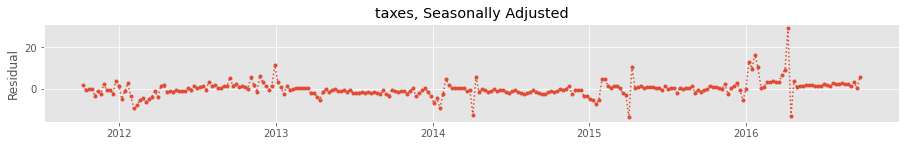

In [22]:
for search_term in ['baseball', 'taxes']:
    seasonal_fit = helper.fit(google_trends[search_term], method='seasonality', period='week')

    time_series_plotter(seasonal_fit.plot,
            title=f'{search_term}, Google Trends', legend=True, ylabel=data_label)
    time_series_plotter(seasonal_fit.plot, 
            title=f'{search_term}, Seasonally Adjusted', **resid_params)

## Time Series Decomposition

The **Classical Decomposition** expresses a time series as the sum of three components: **trend**, **seasonality**, and **remainder/residual/random**

$$ y_t = T_t + S_t + R_t $$

Suppose that we have a time series with *weekly* observations so that one calender year consists of 52 observations. The classical decomposition of the time series is performed as follows:

1. Compute the trend component $T_t$ using a moving average with window width 52 (or 12 for monthly data) and then detrend the series.
2. Compute the seasonal component $S_t$ of the detrended series $y_t - T_t$ by averaging observations from the same week (or month for monthly data) of the year and then seasonally adjust the detrended series.
**Note:** this is *equivalent* to fitting a linear regression to the detrended data with an indicator/dummy variable for each week and then getting the predictions for each week of the original series.
3. The **remainder**, or **residual**, or **random** component $R_t$ is $y_t - T_t - S_t$.

`statsmodels` implements the classical decomposition as `seasonal_decompose`.

**Note:** Different components of the time series are often shown on different scales so pay attention to the $y$-axes.

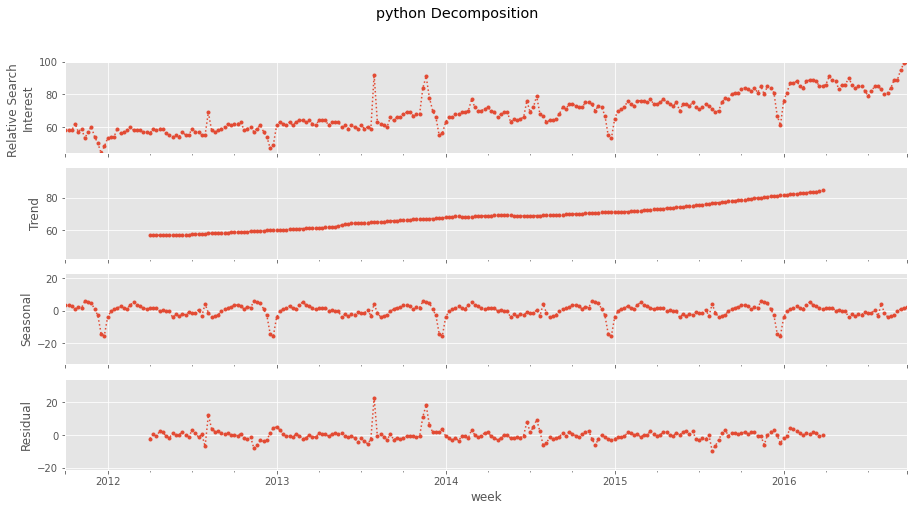

In [23]:
search_term = 'python'
plot_seasonal_decompose(google_trends[search_term])

Our earlier observation that this series has an increasing trend with seasonal year-end dips is supported by the decomposition. 

When the decomposition is sufficient, the residual component $R_t$ should show no seasonal or trend patterns.

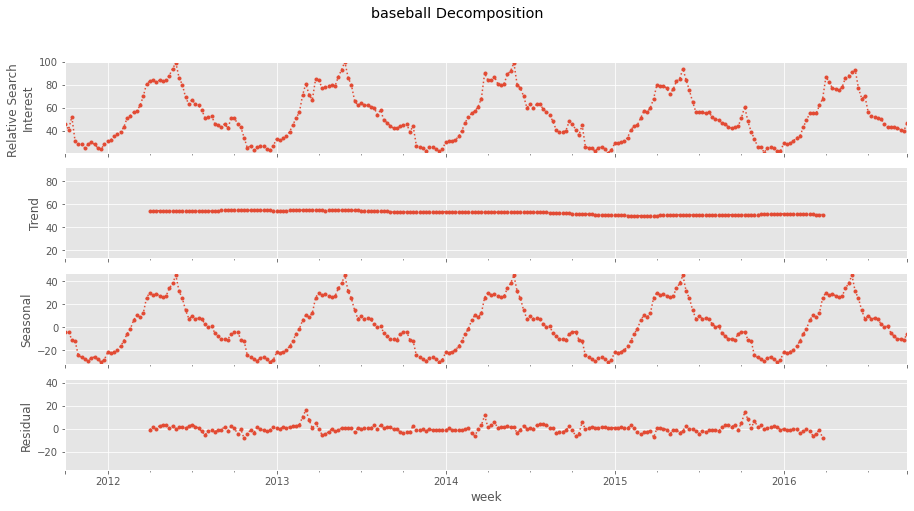

In [24]:
search_term = 'baseball'
plot_seasonal_decompose(google_trends[search_term])

Most of the variation in this series is captured by the seasonal component.

**Activity:** Decompose the `data-science` series.  What patterns do you see?  Is the decomposition appropriate?

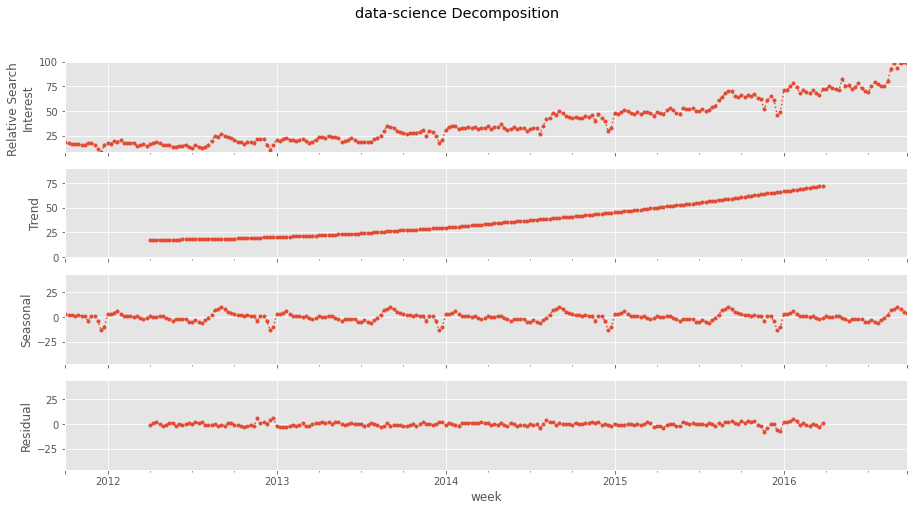

In [25]:
search_term = 'data-science'
plot_seasonal_decompose(google_trends[search_term])

**Question:** If you detrend and seasonally adjust a time series, does the order matter?

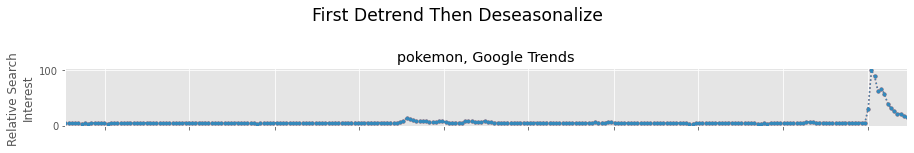

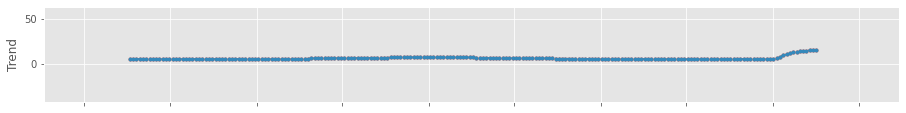

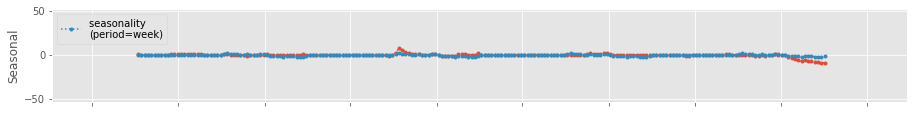

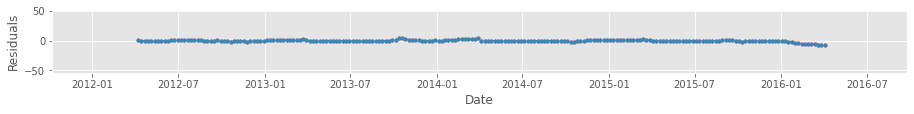

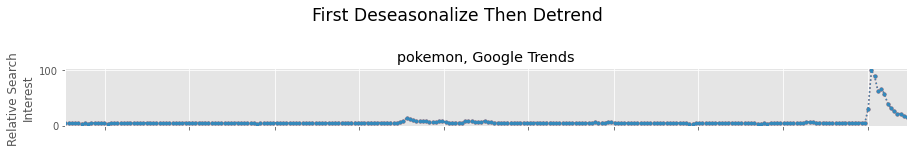

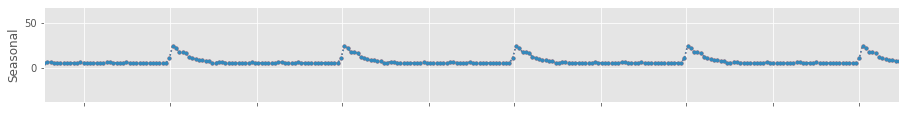

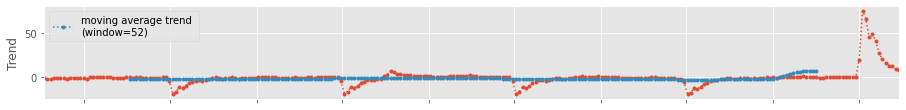

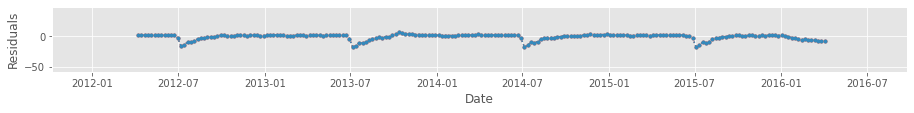

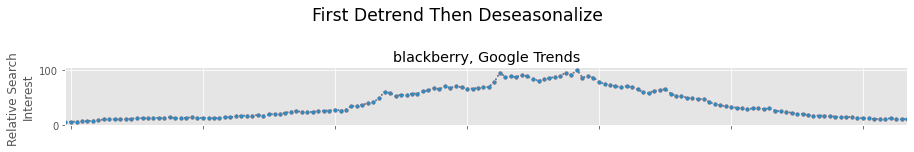

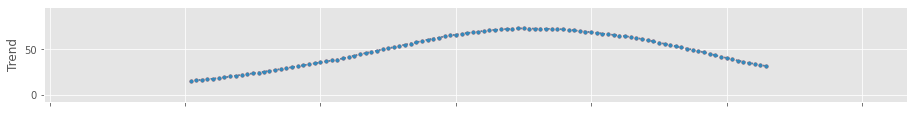

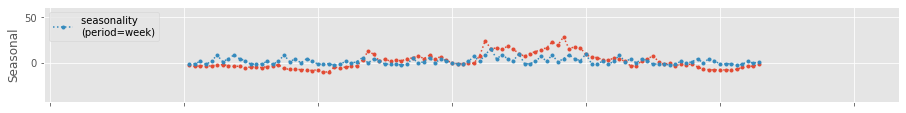

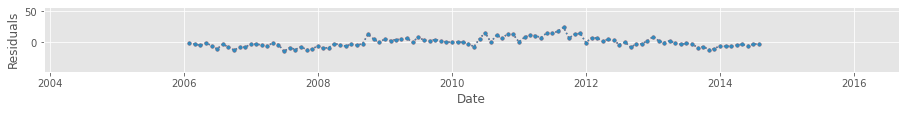

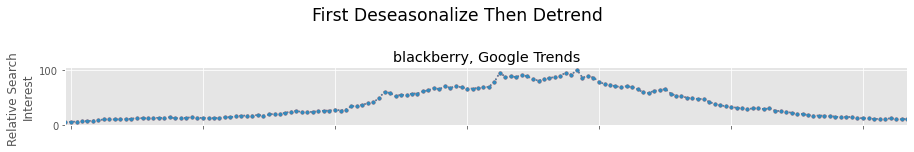

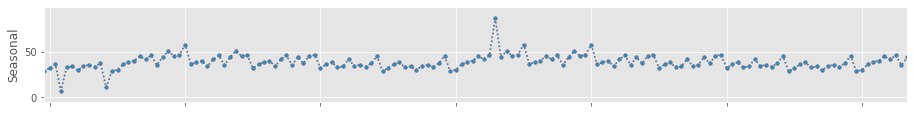

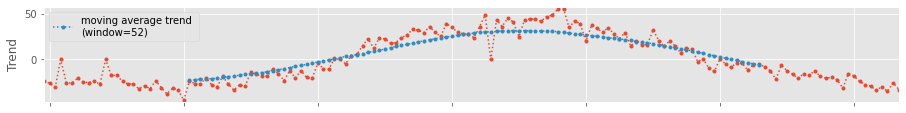

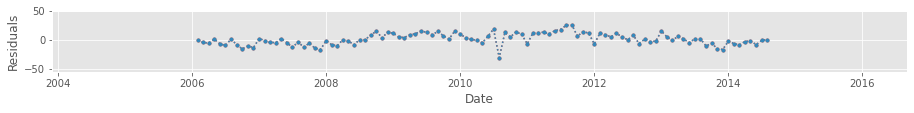

In [26]:
figsize = (6.4 * 2, 4.8 / 5 * 2)

for search_term in ['pokemon', 'blackberry']:
    series_raw = google_trends[search_term]

    # axis settings
    xlim = (google_trends[search_term].index[0], google_trends[search_term].index[-1])
    x_params = {'xlim': xlim, 'xticklabels': []}
    y_halfrange = (series_raw.max() - series_raw.min()) / 2
    
    
    # first detrend then deseasonalize
    # time series
    time_series_plotter(helper.fit(google_trends[search_term]).plot, 
            figsize=figsize,
            suptitle='First Detrend Then Deseasonalize', 
            title=f'{search_term}, Google Trends', 
            ylabel=data_label, 
            ylim=ylim_rescale(series_raw, y_halfrange),  
            **x_params)

    # moving average trend
    moving_average_fit = helper.fit(google_trends[search_term], method='moving average', window=52)
    series_moving_average = moving_average_fit.fitted
    series_detrended = moving_average_fit.resid.dropna()
    time_series_plotter(helper.fit(series_moving_average).plot, 
            figsize=figsize,
            ylabel='Trend',
            ylim=ylim_rescale(series_moving_average, y_halfrange),
            **x_params)

    # seasonality of detrended series
    detrended_seasonal_fit = helper.fit(series_detrended, method='seasonality', period='week')
    time_series_plotter(detrended_seasonal_fit.plot,
            figsize=figsize,
            ylabel='Seasonal', 
            ylim=ylim_rescale(series_detrended, y_halfrange),
            legend=True,
            **x_params)

    #residuals after detrending then deseasonalizing
    series_detrended_deseasonalized = detrended_seasonal_fit.resid
    time_series_plotter(helper.fit(series_detrended_deseasonalized).plot, 
            figsize=figsize,
            xlabel='Date',
            ylabel='Residuals',
            xlim=xlim,
            ylim=ylim_rescale(series_detrended_deseasonalized, y_halfrange))

    
    
    
    # first deseasonalize then detrend
    # time series
    time_series_plotter(helper.fit(google_trends[search_term]).plot, 
            figsize=figsize,
            suptitle=f'First Deseasonalize Then Detrend',
            title=f'{search_term}, Google Trends', 
            ylabel=data_label,
            ylim=ylim_rescale(series_raw, y_halfrange),
            **x_params)

    # seasonality
    seasonal_fit = helper.fit(google_trends[search_term], method='seasonality', period='week')
    series_seasonal = seasonal_fit.fitted
    series_deseasonalized = seasonal_fit.resid
    time_series_plotter(helper.fit(series_seasonal).plot,
            figsize=figsize,
            ylabel='Seasonal',
            ylim=ylim_rescale(series_seasonal, y_halfrange),
            **x_params)

    # moving average trend of deseasonalized series
    deseasonalized_moving_average_fit = helper.fit(series_deseasonalized, method='moving average', window=52)
    time_series_plotter(deseasonalized_moving_average_fit.plot,
            figsize=figsize,
            ylabel='Trend',
            ylim=ylim_rescale(series_deseasonalized, y_halfrange),
            legend=True, 
            **x_params)

    # residuals after deseasonalizing then detrending
    series_deseasonalized_detrended = deseasonalized_moving_average_fit.resid.dropna()
    time_series_plotter(helper.fit(series_deseasonalized_detrended).plot, 
            figsize=figsize,
            xlabel='Date',
            ylabel='Residuals',
            xlim=xlim,
            ylim=ylim_rescale(series_deseasonalized_detrended, y_halfrange))

## Stochastic Processes

So far we have only considered the time series as

$$ y_1, y_2, y_3, \ldots y_n$$

Let's impose a mathematical model on this data.

Formally, time series data is a **sample** from a **collection of random variables**

$$\{ Y_1, Y_2, Y_3, \ldots Y_n\}$$

We do **not** assume that these random variables are independent. **It is common in a time series that the sample at time $t$ influences the sample at time $t+1$**.

To distinguish the data from the mathematical model that (we assume) generated the data, we say:

  - The data are a **time series**.
  - The mathematical model here is a **stochastic** or **random process.**

### White Noise

**White noise** is a simple kind of random process that is a collection of uncorrelated random variables ($Y_i \perp\!\!\!\perp Y_j, \forall i \neq j$ so the pdf of the joint probability of $Y_i$ and $Y_j$ is the product of their pdfs) with a mean of zero ($\mu = 0$) and finite variance. 

For convenience in our examples, we will have the $Y_t \stackrel{iid}{\sim} N(0, 1)$ so that the process is **gaussian white noise.**

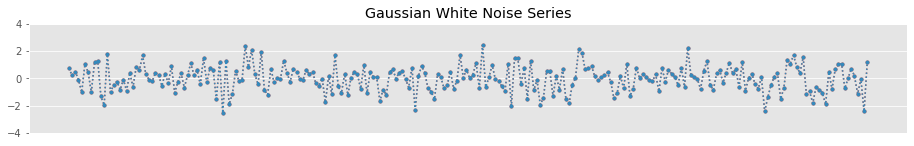

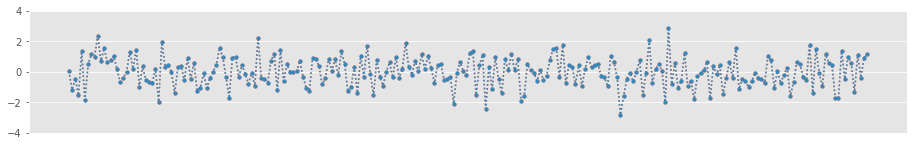

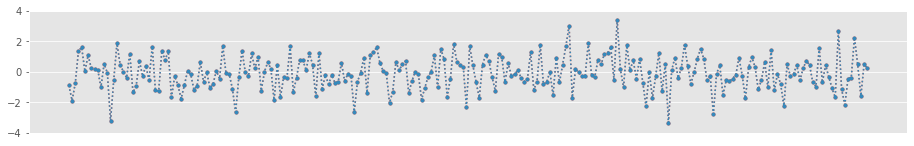

In [27]:
n = 3

for i in range(3):
    title=''
    if i == 0:
        title = 'Gaussian White Noise Series'

    time_series_plotter(helper.fit(gaussian_white_noise()).plot, title=title, xticks=[], ylim=(-4, 4))

White noise shows no trend, no seasonality, no cyclical pattern, and no stickiness.

### Random Walks

Cumulatively summing, or integrating, a white noise series produces a **random walk**. We can build a random walk as follows

$$ y_0 = e_0$$  
$$ y_1 = y_0 + e_1$$  
$$ y_{t+1} = y_t + e_t $$

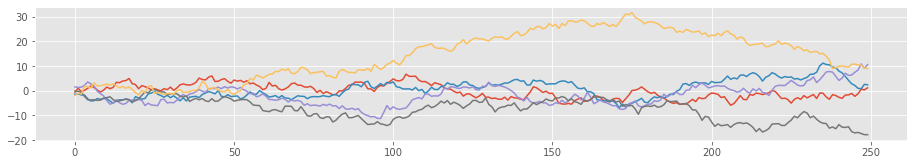

In [28]:
# n random walks ... plotted
n = 5

fig, ax = plt.subplots(figsize=(6.4 * 2, 4.8 / 2), tight_layout=True)
for _ in range(n):
    ax.plot(random_walk())

plt.show()

Random walks can show evidence of *trends* even though every step is random because **random walks have positive autocorrelation** (**random walks are sticky**.) When a random walk makes an extreme level change, subsequent steps are still random and have no tendency to reverse the level change, so the value of the series stays at the extreme level until another extreme change randomly occurs.

### Stationarity

A random process $Y_1, Y_2, Y_3, \ldots Y_n$ is said to be **strictly stationary** if the distribution of all time shifted sets taken from the collection are identical.  That is, if

$$ \{Y_{1}, Y_{2}, Y_{3} \ldots, Y_{t}\} $$

and

$$ \{Y_{1 + k}, Y_{2 + k}, Y_{3 + k}\ldots, Y_{t + k}\} $$

are identically distributed for all $k$.

This means that the probabilistic properties of the series **do not** depend on when you begin observing it.

This means that if you start observing the series for an hour, go cook a meal for an hour, then observe the series for another hour, the properties of the sequences you observed before and after the meal will be the same!

Strict stationarity is difficult to assess from a single time series and too strong for most applications. In practice, stationarity will refer to **weak stationarity**, where we only require that the mean and variance of the series does not change when shifted in time and the covariance between lagged random variables only depends on the time shift $k$ and not on the specific time point

$$\text{E}(Y_t) = \mu  $$  
$$\text{Var}(Y_t) = \sigma_Y^2$$  
$$\text{Cov}(Y_t, Y_{t + k}) = \gamma(k)$$

**White noise is an example of a stationary process.**

Here are a few series that are nonstationary.

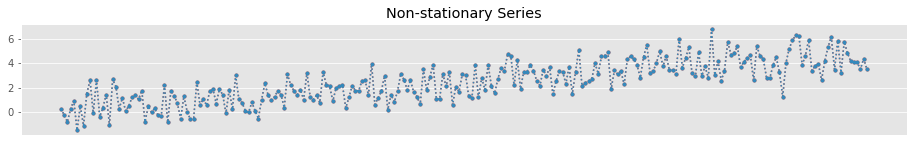

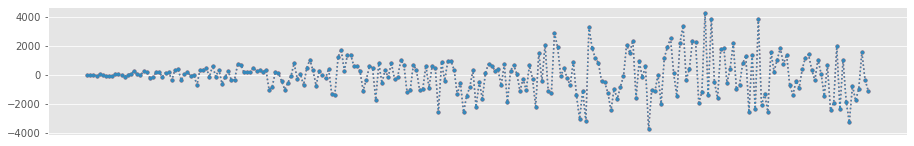

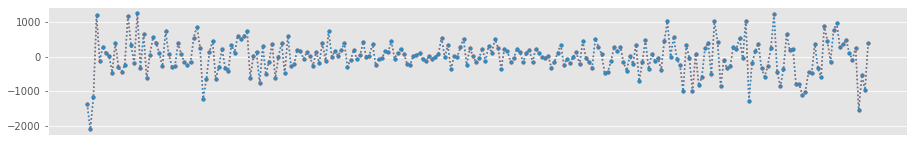

In [29]:
# more examples of non-stationary data
x = np.arange(250)
xticks=[]

y_1 = stats.norm(x / 50, 1).rvs(250)
time_series_plotter(helper.fit(y_1).plot, xticks=xticks, title='Non-stationary Series')
y_2 = stats.norm(0, x * 10).rvs(250)
time_series_plotter(helper.fit(y_2).plot, xticks=xticks)
y_3 = stats.norm(0, (x - 125)**2/20 + 200).rvs(250)
time_series_plotter(helper.fit(y_3).plot, xticks=xticks)

**Discussion:** Can stationary series show trends?  Can stationary series show seasonality?

**Discussion:** Can the variance of a stationary series change over time?

[Which of these series is stationary?](https://otexts.com/fpp3/stationarity.html)

To use the ARIMA models introduced later in this notebook, we will need to transform our time series to stationarity. This will involve removing trends and heteroscedasticity.

### Differencing

In contrast to the detrending and deseasonalizing achieved by decomposition, **differencing** is another method to remove these components.

Given a time series  
$$y_1, y_2, y_3, \ldots y_n$$
the **first difference** series is

$$ y_2 - y_1, y_3 - y_2, y_4 - y_3, \ldots y_n - y_{n - 1}$$

Differencing adjacent observations removes level changes in a series due to trend, which stationary series cannot have. Seasonal differencing is an extension for removing seasonality.

In [30]:
# using series.diff to make a time series stationary
pd.Series([2,4,5,8]).diff()

0    NaN
1    2.0
2    1.0
3    3.0
dtype: float64

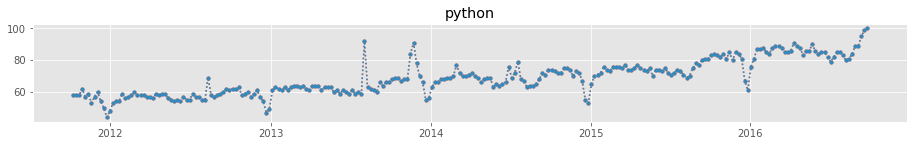

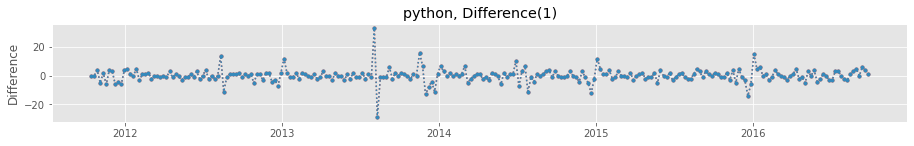

In [31]:
search_term = 'python'
plot_series_and_difference(google_trends[search_term])

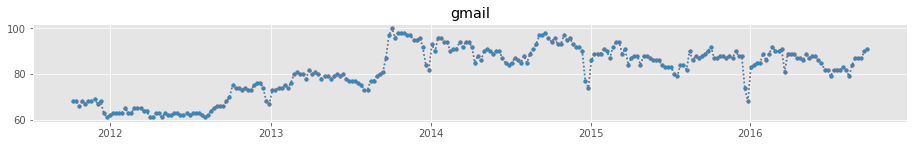

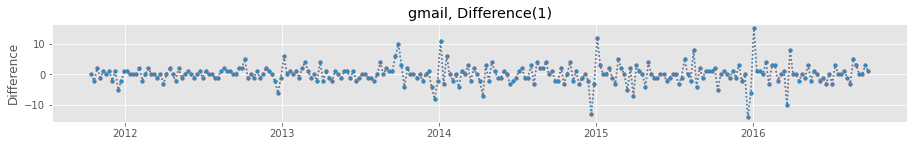

In [32]:
search_term = 'gmail'
plot_series_and_difference(google_trends[search_term])

**Discussion:** Do these difference series look stationary?

**Activity:** Compute and plot the first difference series for `data-science`.  Does it look stationary?

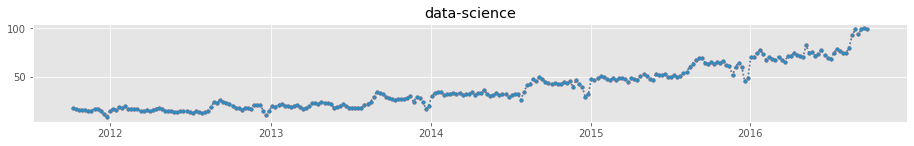

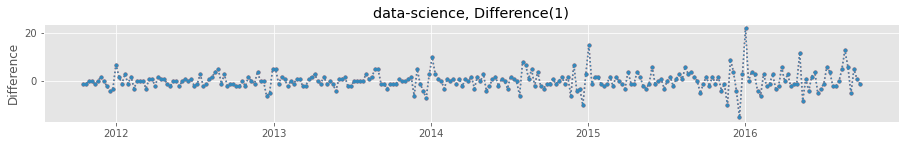

In [33]:
search_term = 'data-science'
plot_series_and_difference(google_trends[search_term])

**Question:** If you are given the *difference* of a series, how can you recover the original series?

In [34]:
search_term = 'gmail'
series = google_trends[search_term]
series_diff = google_trends[search_term].diff()

np.all(series_diff.fillna(series[0]).cumsum() == series)

True

### Linear Combinations of White Noise

We can construct a diverse set of stationary series from **linear combinations of white noise**.

Suppose that 

$$ e_1, e_2, e_3, \ldots e_n$$

is a gaussian white noise series (what was that again?) Then any series created by linearly combining lagged values of $e_t$ is stationary

$$ y_t = \mu_t + e_t + \theta_1 e_{t-1} + \theta_2 e_{t-2} + \cdots + \theta_q e_{t-q} $$

In [35]:
def linear_combination_of_white_noise(size, coef):
    coef = np.asarray(coef)
    n_coef = len(coef)
    noise_size = size + len(coef)
    noise = np.random.normal(size=noise_size)
    # np.convolve reverses the second array :/
    # We need to subset the result to remove edge effects.
    lc = np.convolve(noise, coef[::-1])[(n_coef-1):(size+n_coef-1)]
    return pd.Series(lc)

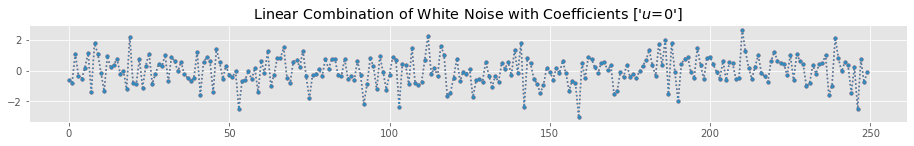

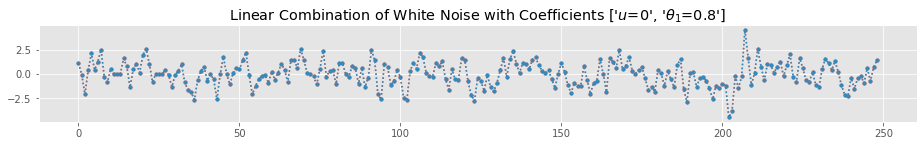

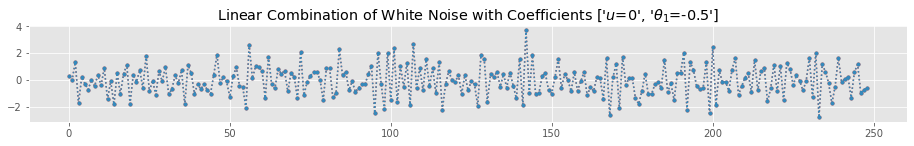

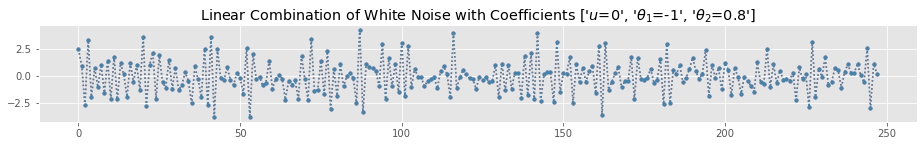

In [36]:
coefs = [[1], [1, 0.8], [1, -0.5], [1, -1, 0.8]]
size = 250

for coef in coefs:
    thetas = [f'$u$=0']
    thetas.extend([f'$\theta_{i}$={coef[i]}' for i in range(1, len(coef))])
    time_series_plotter(helper.fit(ma(coef)).plot, 
                        title=f'Linear Combination of White Noise with Coefficients {thetas}')

**All the series above are sampled from stationary processes.**

A linear combination of gaussian white noise is called an **MA(q) model** where $q$ is the order or the number of MA coefficients.

  - An MA(1) model contains one lagged term: $y_t = \mu + e_t + \theta_1 e_{t-1}$
  - An MA(2) model contains two lagged terms: $y_t = \mu + e_t + \theta_1 e_{t-1} + \theta_2 e_{t-2}$
  - And so on...
  
**Note:**  MA stands for *moving average*, even though this is not the same as the moving average as we discussed earlier.  Unfortunately, the name has stuck and we recommend you call them "em ay" series, reserving the full words for moving averages as commonly understood.

**Activity:** Take a few minutes to [play around](https://www.geogebra.org/m/TK73Dk6u) with generating some MA series.  Can you create any interesting behavior?

**Discussion:** What sort of real-life process would create an MA series?

### Tests for Stationarity

Stationarity is hard to visualize so there are statistical tests that you can use to determine stationarity.

The **Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test** has the following hypotheses:

  - $H_0$: The series is stationary.  
  - $H_{\text{a}}$: The series is **nonstationary**.

It is available in `statsmodels` as `tsa.stattools.kpss`.

The **Augmented Dickey-Fuller test** has the following hypotheses:

  - $H_0$: The series is **nonstationary**.
  - $H_{\text{a}}$: The series is stationary.

It is available in `statsmodels` as `tsa.stattools.adfuller`.

If a series is nonstationary you should difference it up to two times until it is stationary.

[Empirically, KPSS tests lead to models with better forecasts](https://robjhyndman.com/hyndsight/unit-root-tests/)

**Note**: The KPSS and ADF tests cannot detect nonstationarity due to seasonality or due to heteroskedasticity.

White noise series are stationary:

C:\Users\K\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1876: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(warn_msg.format(direction="greater"), InterpolationWarning)


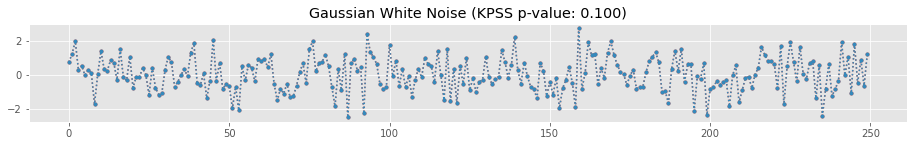

In [37]:
series = gaussian_white_noise()

test = sm.tsa.stattools.kpss(series, nlags='auto')
time_series_plotter(helper.fit(series).plot, title=f'Gaussian White Noise (KPSS p-value: {test[1]:.3f})')

MA(q) series are stationary:

C:\Users\K\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1876: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(warn_msg.format(direction="greater"), InterpolationWarning)


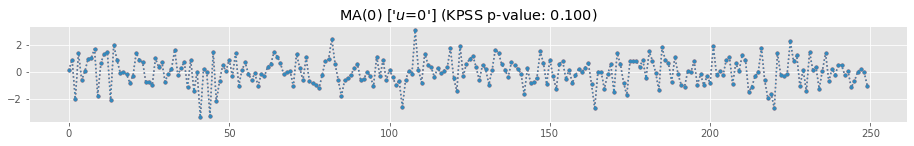

C:\Users\K\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1876: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(warn_msg.format(direction="greater"), InterpolationWarning)


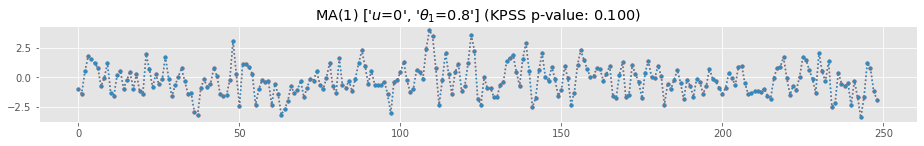

C:\Users\K\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1876: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(warn_msg.format(direction="greater"), InterpolationWarning)


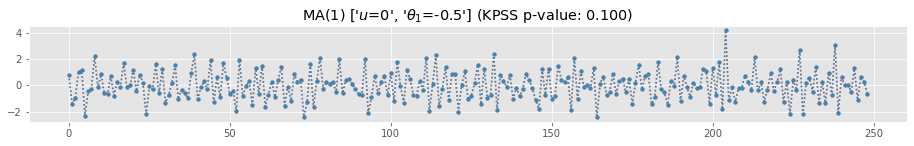

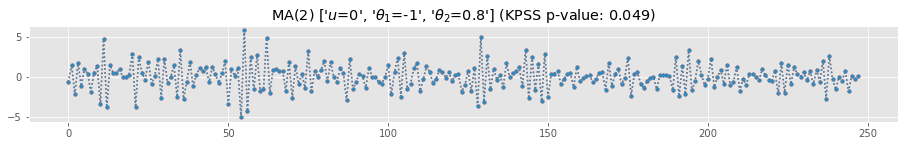

In [38]:
for coef in coefs:
    series = ma(coef=coef)
    test = sm.tsa.stattools.kpss(series, nlags='auto')

    thetas = [f'$u$=0']
    thetas.extend([f'$\theta_{i}$={coef[i]}' for i in range(1, len(coef))])
    time_series_plotter(helper.fit(series).plot, 
                        title=f'MA({len(coef) - 1}) {thetas} (KPSS p-value: {test[1]:.3f})')

What about some of the Google Trends series?

The python series has an obvious trend so it is nonstationary and the test confirms this.

C:\Users\K\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1874: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(warn_msg.format(direction="smaller"), InterpolationWarning)


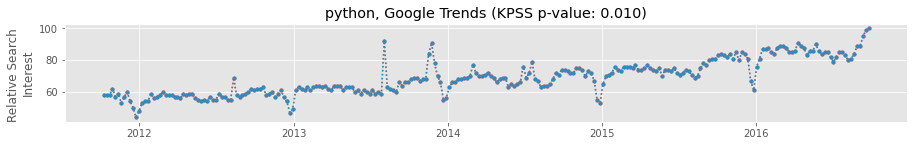

In [39]:
search_term = 'python'

series = google_trends[search_term]
test = sm.tsa.stattools.kpss(series, nlags='auto')
time_series_plotter(helper.fit(series).plot, 
                        title=f'{series.name}, Google Trends (KPSS p-value: {test[1]:.3f})', ylabel=data_label)

Does differencing help?

C:\Users\K\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1876: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(warn_msg.format(direction="greater"), InterpolationWarning)


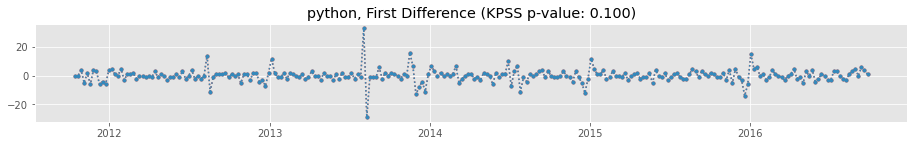

In [40]:
search_term = 'python'

series = google_trends[search_term].diff().dropna()
test = sm.tsa.stattools.kpss(series, nlags='auto')
time_series_plotter(helper.fit(series).plot, 
                    title=f'{series.name}, First Difference (KPSS p-value: {test[1]:.3f})')

The baseball series is also stationary after differencing.  

**Note**: The KPSS test cannot detect nonstationarity due to seasonality.

C:\Users\K\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1876: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(warn_msg.format(direction="greater"), InterpolationWarning)


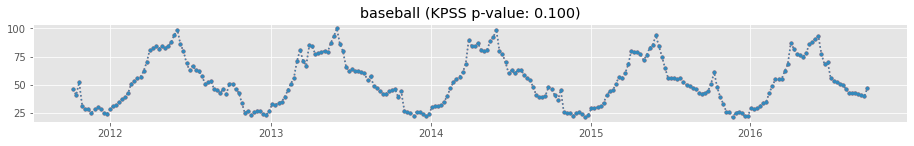

C:\Users\K\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1876: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(warn_msg.format(direction="greater"), InterpolationWarning)


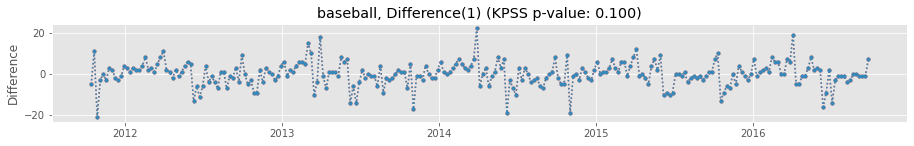

In [41]:
search_term = 'baseball'

series = google_trends[search_term]
plot_series_and_difference(series, test=True)

**Activity:** Test the `data-science` series for stationarity.  Does differencing improve the situation?

C:\Users\K\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1874: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(warn_msg.format(direction="smaller"), InterpolationWarning)


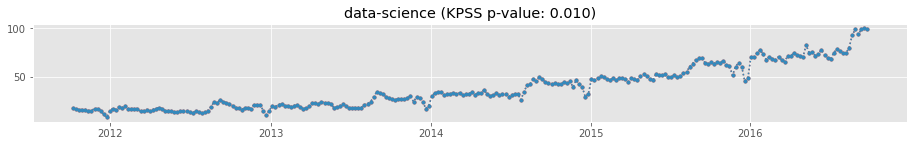

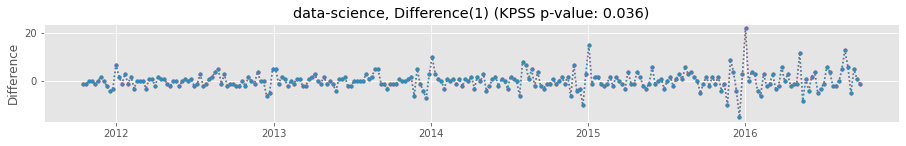

In [42]:
search_term = 'data-science'

series = google_trends[search_term]
plot_series_and_difference(series, test=True)

**Final Activity:** Can you transform the `earnings` series from earlier to be stationary?

C:\Users\K\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1874: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(warn_msg.format(direction="smaller"), InterpolationWarning)


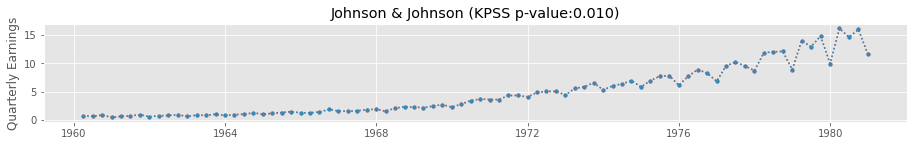

In [43]:
jj = pd.read_csv('data/jj.txt').earnings
jj.index = pd.date_range('1960', '1981', freq='Q')
series = jj

test = sm.tsa.stattools.kpss(jj, nlags='auto')
time_series_plotter(helper.fit(series).plot, title=f'Johnson & Johnson (KPSS p-value:{test[1]:.3f})', 
                    ylabel='Quarterly Earnings')

  - How would you stabilize the variance?  [See 'Mathematical transformations'](https://otexts.com/fpp3/transformations.html)
  - [How Could You Benefit from a Box-Cox Transformation?](https://blog.minitab.com/blog/applying-statistics-in-quality-projects/how-could-you-benefit-from-a-box-cox-transformation)

C:\Users\K\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1874: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(warn_msg.format(direction="smaller"), InterpolationWarning)


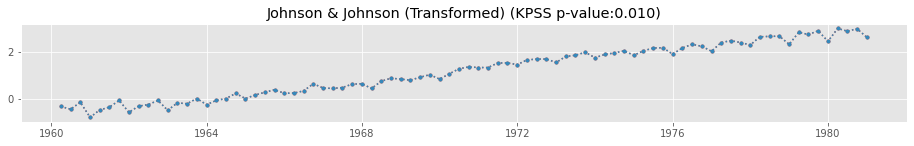

In [44]:
# decrease heteroscedacity using a log transformation
jj_box_cox, lmbda = stats.boxcox(jj)
jj_box_cox = pd.Series(jj_box_cox, index=jj.index, name='Johnson & Johnson Earnings (Transformed)')
series = jj_box_cox

test = sm.tsa.stattools.kpss(series, nlags='auto')
time_series_plotter(helper.fit(series).plot, title=f'Johnson & Johnson (Transformed) (KPSS p-value:{test[1]:.3f})')

  - How would you remove the trend and seasonality?

C:\Users\K\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1876: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(warn_msg.format(direction="greater"), InterpolationWarning)


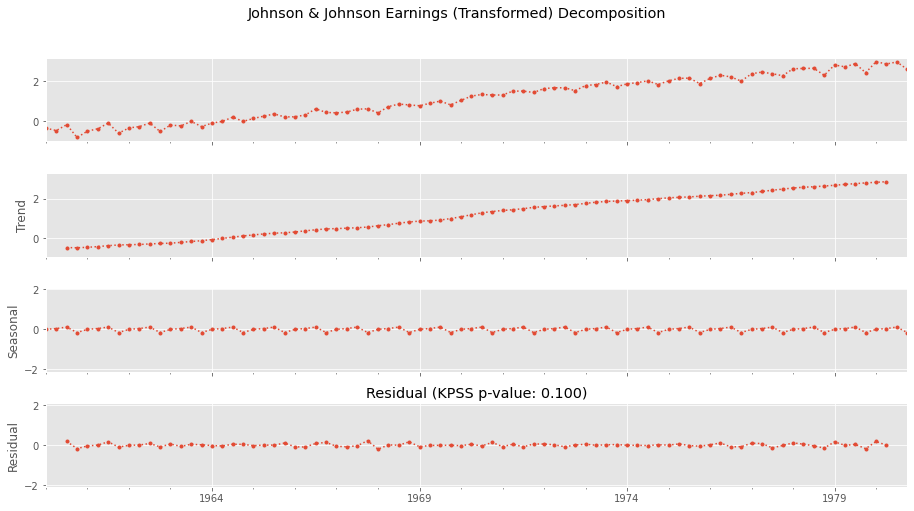

In [45]:
# remove trend and seasonality through decomposition
plot_seasonal_decompose(jj_box_cox, test=True, y_margin=0.1, series_label='')

C:\Users\K\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1876: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(warn_msg.format(direction="greater"), InterpolationWarning)
C:\Users\K\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1876: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(warn_msg.format(direction="greater"), InterpolationWarning)


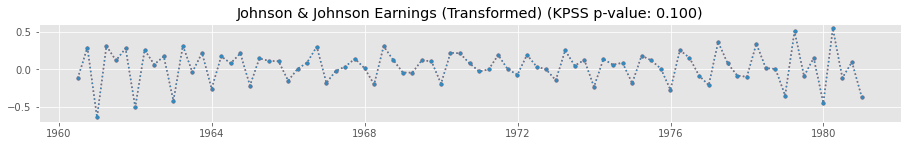

C:\Users\K\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1876: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(warn_msg.format(direction="greater"), InterpolationWarning)


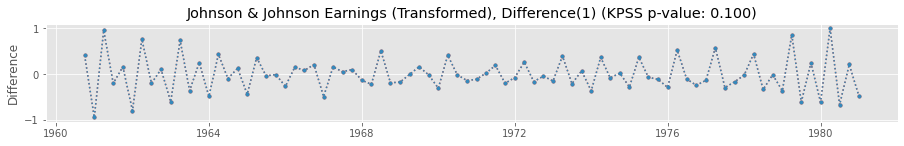

In [46]:
# remove trend using first difference
series = jj_box_cox.diff().dropna()
test = sm.tsa.stattools.kpss(series, nlags='auto')
plot_series_and_difference(series, test=True)

# Time Series - ARIMA Models

For the rest of the lecture, we will be working with *stationary* series, and developing a statistical model for them.

## Autocorrelation

Recall the definition of strictly stationary.

A time series $Y_1, Y_2, Y_3, \ldots$ is said to be **strictly stationary** if the distribution of all equally spaced tuples taken from the series are identical.  That is, if

$$ (Y_{i_1}, Y_{i_2}, \ldots, Y_{i_k}) $$

and

$$ (Y_{i_1 + k}, Y_{i_2 + k}, \ldots, Y_{i_3 + k}) $$

are always identically distributed.

One consequence of this definition is that the correlation between two $Y$'s only depends on the lag between them:

$$ Corr(Y_5, Y_2) = Corr(Y_4, Y_1) = Corr(Y_{144}, Y_{141}) = \cdots $$

These correlations between a time series and a lagged version of itself are called **autocorrelations**.

$$ \gamma_k(Y)= Corr(Y_1, Y_{1+k}) = Corr(Y_2, Y_{2+k}) = Corr(Y_3, Y_{3+k}) = \cdots $$

In [47]:
def series_and_lagged(series, lag=1):
    truncated = np.copy(series)[lag:]
    lagged = np.copy(series)[:(len(truncated))]
    return truncated, lagged

def compute_autocorrelation(series, lag=1):
    series, lagged = series_and_lagged(series, lag=lag)
    return np.corrcoef(series, lagged)[0, 1]

Recall from earlier that the differenced baseball series **is** stationary (according to the ADF test).

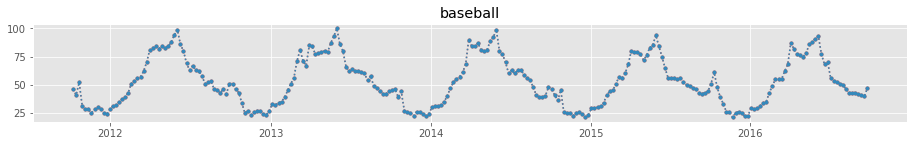

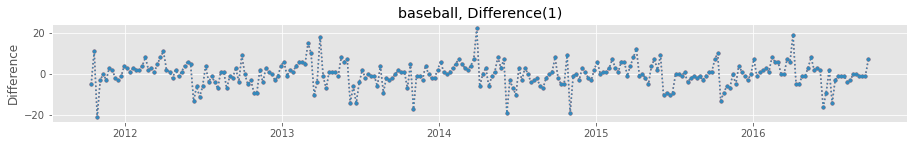

In [48]:
search_term = 'baseball'

series = google_trends[search_term]
plot_series_and_difference(series)

What is the differenced series?  What is the goal of time series? 

We can draw some scatterplots to summarize the autocorrelation information in the baseball series.

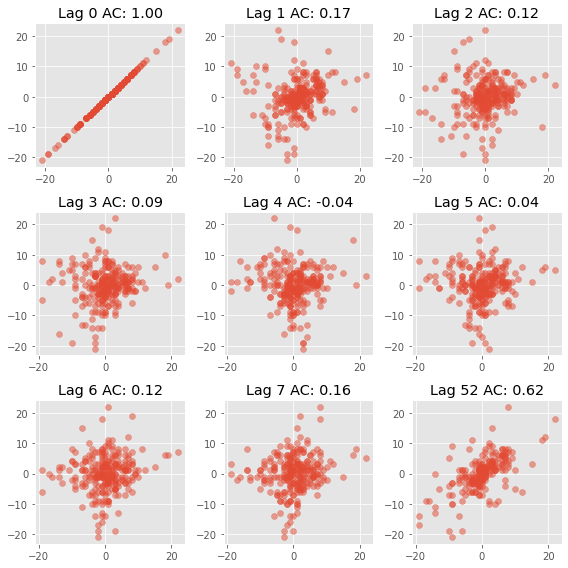

In [49]:
baseball_diff = google_trends['baseball'].diff()[1:]

fig, axs = plt.subplots(3, 3, figsize=(8, 8))

lags = [0,1,2,3,4,5,6,7,52]

for i, ax in zip(lags,axs.flatten()):
    series, lagged = series_and_lagged(baseball_diff, lag=i)
    autocorr = compute_autocorrelation(baseball_diff, lag=i)
    ax.scatter(series, lagged, alpha=0.5)
    ax.set_title("Lag {0} AC: {1:2.2f}".format(i, autocorr))
    
plt.tight_layout()

**Question:** Why does the first scatterplot here lie along a straight line?

A more immediate way to view the autocorrelation in a series is with an **autocorrelation plot**.  

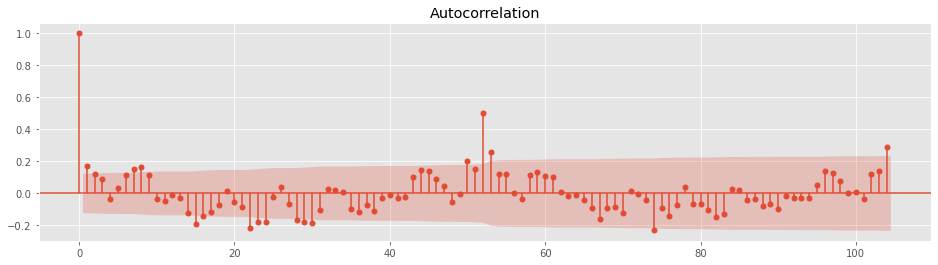

In [50]:
fig, ax = plt.subplots(1, figsize=(16, 4))

_ = sm.graphics.tsa.plot_acf(baseball_diff, lags=2*52, ax=ax)

Each spike in this plot is an autocorrelation for a single lag.

**In this example, we are doing over 100 correlations of the data with itself, each one at a different lag value.**

The x-axis here is the lag $k$. The value of the autocorrelation at lag $k$ is the correlation between the series $y_t$ and the lagged series $y_{t-k}$

The *first* spike is always at $1.0$ (because any series is perfectly correlated with itself.

The shaded region are 95% confidence bounds.  If *all* of the autocorrelations were truly zero, we would still expect to see about 5% of the spikes exceeding these bounds.

For the baseball example, we observe the following:
  - There is a very striking spike at exactly 52 lags, which is the number of weeks in a year.  This is repeated, less significantly, at a lag of twice 52.
  - The first and 53rd autocorrelations are positive and significant.

**Discussion:** How do you interpret the large spike in autocorrelation at $52$ weeks?

**Discussion:** Could the spike at $104$ weeks be related to the spike at $52$ weeks?

**Discussion:** Does the spike at 52 weeks *prevent the series from being stationary*?

One potential issue with autocorrelations is the following:
    
If $y_i$ influences $y_{i+1}$ **and** $y_{i+1}$ influences $y_{i+2}$ then $y_{i}$ **necessarily** has some influence on $y_{i+2}$

Said another way, yesterday affects today, and today affects tomorrow.

## Partial Autocorrelation

A **partial autocorrelation** plot controls for this effect. The partial autocorrelation at lag $k$ is the amount of correlation between $y_t$ and $y_{t-k}$ not accounted for by lags $1$ to $k-1$.

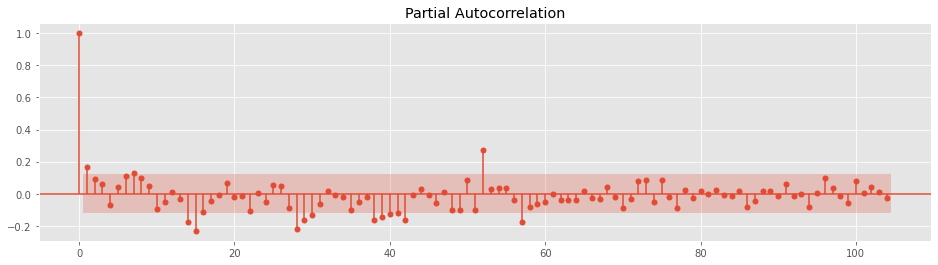

In [51]:
fig, ax = plt.subplots(1, figsize=(16, 4))

_ = sm.graphics.tsa.plot_pacf(baseball_diff, lags=2*52, ax=ax, method='ywmle')

Here, the spike at $52$ weeks still appears, but the subsequent spike at $104$ weeks has disappeared.  This demonstrates that the spike at $104$ weeks was almost completely caused by the spike at $52$ weeks.

**Discussion:** How do you think the partial autocorrelation plot is constructed.  **Hint**: It uses linear regression in a fundamental way.

**Discussion:** What would you expect from an autocorrelation plot of white noise?

### Autocorrelation of MA series

Recall that MA series are linear combinations of white noise with a possible constant term

$$ s_i = \mu + e_i + a_1 e_{i-1} + \cdots + a_k e_{i-k} $$

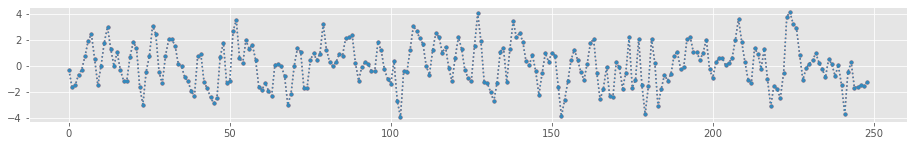

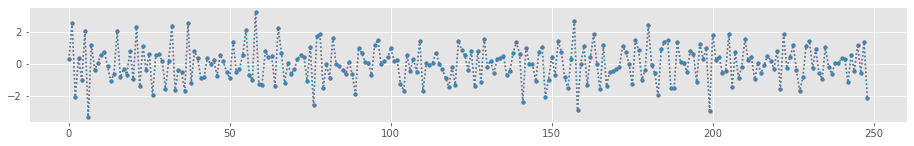

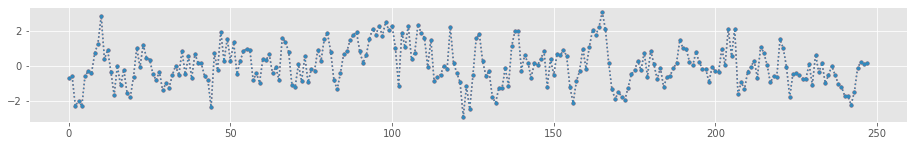

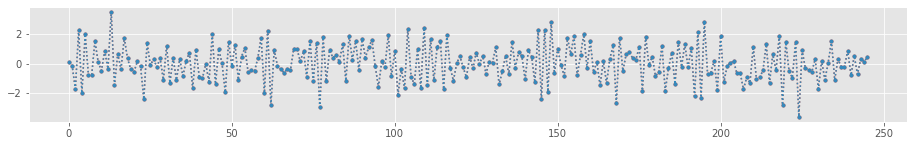

In [52]:
ma_coefs = [[1, 1.0], [1, -0.5], [1, 0.5, 0.5], [1, -0.5, 0.5, -0.25, 0.25]]
for coef in ma_coefs:
    time_series_plotter(helper.fit(ma(coef)).plot)

**Discussion:** What will the autocorrelation of a MA series look like?

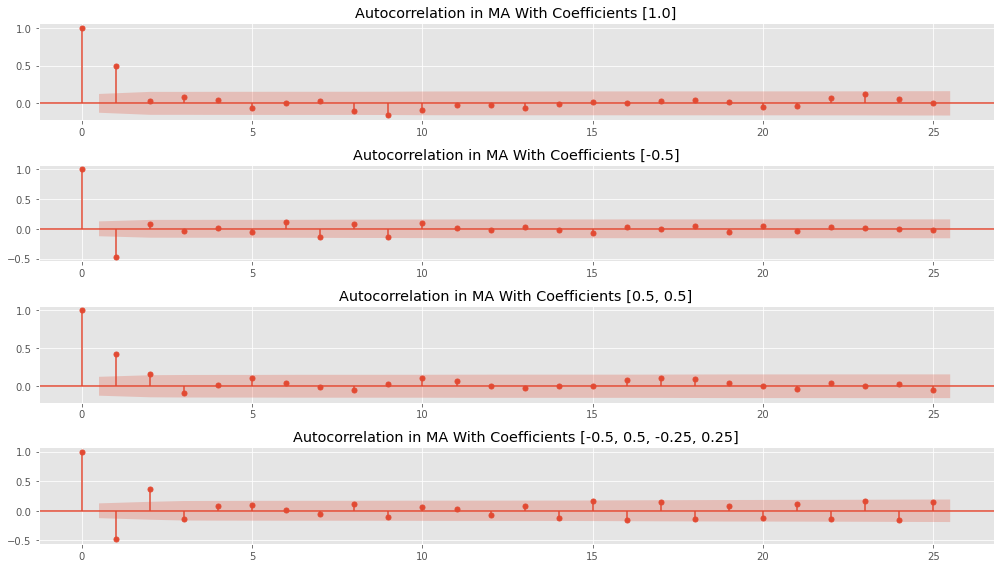

In [53]:
fig, axs = plt.subplots(4, figsize=(14, 8))

for i, (ax, coef) in enumerate(zip(axs, ma_coefs)):
    series = ma(coef)
    _ = sm.graphics.tsa.plot_acf(series, lags=25, ax=ax)
    ax.set_title("Autocorrelation in MA With Coefficients {}".format(str(list(coef[1:]))))
    
plt.tight_layout()

For data generated from an MA model, the number of non-zero autocorrelations generally indicates the *order* of the model (the number of non-zero coefficients).

**Discussion:** Why?

### MA Models

Given stationary time series data, a reasonable question to ask is the following:
    
> Which MA series would be most likely to generate this data?"

This is the concept behind MA models.

A MA (moving average) model of order $k$ (also known as a $MA(k)$ model) attempts to represent a stationary time series as a linear combination of white noise:

$$ s_i = \mu + e_i + a_1 e_{i-1} + \cdots + a_k e_{i-k} $$

**Discussion:** What technique do you think is used to determine the estimated coefficients when an MA model is fit?

If you are interested in seeing how the estimated coefficients are fit in an MA model [look here](https://stats.stackexchange.com/questions/48026/how-is-the-ma-part-of-arma-solved-for)

In [54]:
def fit_ma_model(series, order):
    # ARIMA is a more general model, which we are going to build up
    # in pieces.
    model = ARIMA(series, order=(0, 0, order))
    return model.fit()

Let's generate some MA data, fit MA models, and compare the coefficients.

In [55]:
def format_list_of_floats(L):
    return ["{0:2.2f}".format(f) for f in L]

In [56]:
for coef in ma_coefs:
    ma_series = ma(coef)
    ma_model = fit_ma_model(ma_series, order=(len(coef) - 1))
    print("True Coefficients: {0: <20} Estimated Coefficients: {1: <20}".format(
            str(format_list_of_floats(coef[1:])),
            str(format_list_of_floats(ma_model.params[1:]))))

True Coefficients: ['1.00']             Estimated Coefficients: ['0.95', '0.96']    
True Coefficients: ['-0.50']            Estimated Coefficients: ['-0.43', '0.96']   
True Coefficients: ['0.50', '0.50']     Estimated Coefficients: ['0.51', '0.60', '0.89']
True Coefficients: ['-0.50', '0.50', '-0.25', '0.25'] Estimated Coefficients: ['-0.44', '0.53', '-0.29', '0.33', '0.90']


So it looks like the MA models recover the true coefficients from *actual* MA processes.  So far, so good.

Before we apply the MA model to real data, we need to introduce AR processes, and generalize everything to the ARIMA model.

### AR Processes

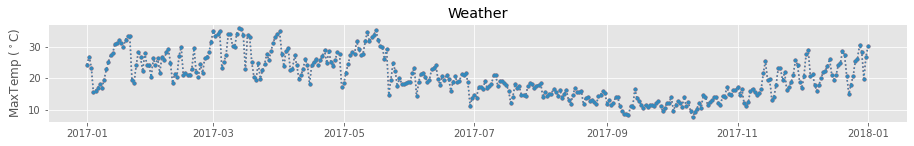

In [57]:
weather = pd.read_csv('data/weather_data.csv', index_col=0, parse_dates=True)
weather_params = {'title':'Weather', 'ylabel':'MaxTemp ($^\circ$C)'}

time_series_plotter(helper.fit(weather.MaxTemp).plot, **weather_params)

We can forecast `MaxTemp` for some future dates by using `MaxTemp` from previous days as predictors. In a univariate time series model the features are the 'lagged' values of the target. 

In [58]:
pd.concat([weather.MaxTemp[i:] for i in range(6)], axis=1, keys=['MaxTemp'] + [f'lag_{i}' for i in range(1, 5 + 1)]).dropna()

MaxTemp  lag_1  lag_2  lag_3  lag_4  lag_5
Date                                                  
2017-01-06     16.9   16.9   16.9   16.9   16.9   16.9
2017-01-07     18.2   18.2   18.2   18.2   18.2   18.2
2017-01-08     17.0   17.0   17.0   17.0   17.0   17.0
2017-01-09     19.5   19.5   19.5   19.5   19.5   19.5
2017-01-10     22.8   22.8   22.8   22.8   22.8   22.8
...             ...    ...    ...    ...    ...    ...
2017-12-28     30.7   30.7   30.7   30.7   30.7   30.7
2017-12-29     28.4   28.4   28.4   28.4   28.4   28.4
2017-12-30     19.9   19.9   19.9   19.9   19.9   19.9
2017-12-31     26.9   26.9   26.9   26.9   26.9   26.9
2018-01-01     30.2   30.2   30.2   30.2   30.2   30.2

[361 rows x 6 columns]

Another data generating process that (often, there are some restrictions on the coefficients) results in a stationary process is an **autoregressive** process.

In an autoregressive process, subsequent values of the series are linear combinations of previous values of the series plus some noise term (much like in regression we get a linear combination of predictors plus a noise term)

$$ y_i = \mu + b_1 y_{i-1} + b_2 y_{i-2} + \cdots + b_k y_{i-k} + \epsilon_i $$

The number of coefficients in this equation is called the *order* of the model, and we often speak of $AR(1)$ processes, $AR(2)$ processes, etc...

In [59]:
def auto_regressive_process(size, coefs, init=None):
    """Generate an autoregressive process with Gaussian white noise.  The
    implementation is taken from here:
    
      http://numpy-discussion.10968.n7.nabble.com/simulate-AR-td8236.html
      
    Exaclty how lfilter works here takes some pen and paper effort.
    """
    coefs = np.asarray(coefs)
    if init == None:
        init = np.array([0]*len(coef))
    else:
        init = np.asarray(init)
    init = np.append(init, np.random.normal(size=(size - len(init))))
    assert(len(init) == size)
    a = np.append(np.array([1]), -coefs)
    b = np.array([1])
    return pd.Series(signal.lfilter(b, a, init))

def plot_autoregressive_process(ax, size, coefs, init=None):
    ar = auto_regressive_process(size, coefs, init)
    ax.plot(ar.index, ar)

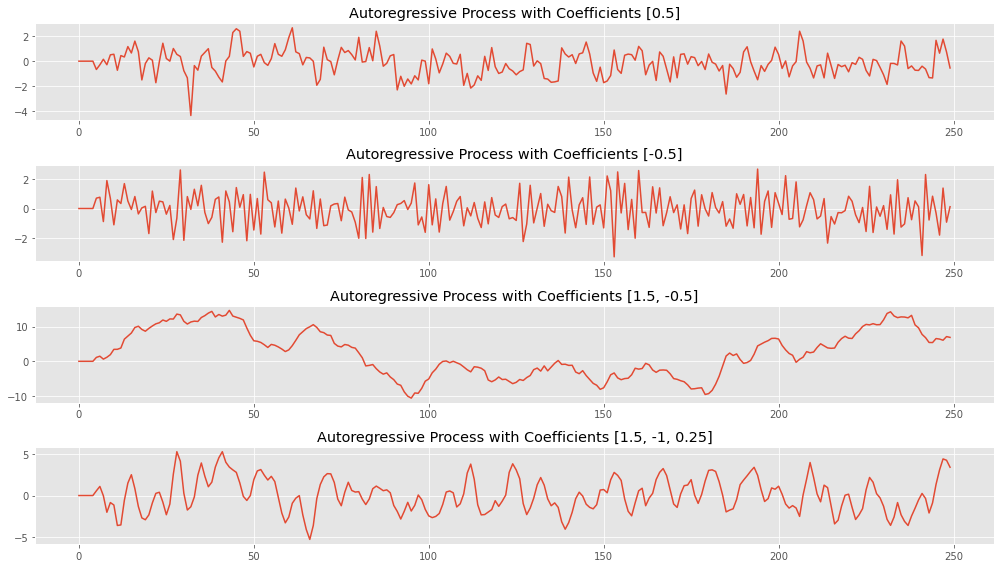

In [60]:
ar_coefs = [[0.5], [-0.5], [1.5, -0.5], [1.5, -1, 0.25]]

fig, axs = plt.subplots(4, figsize=(14, 8))

for i, (ax, coefs) in enumerate(zip(axs, ar_coefs)):
    plot_autoregressive_process(ax, 250, coefs)
    ax.set_title("Autoregressive Process with Coefficients {}".format(str(list(coefs))))

plt.tight_layout()

**Discussion:** What will the autocorrelation of an AR series look like?

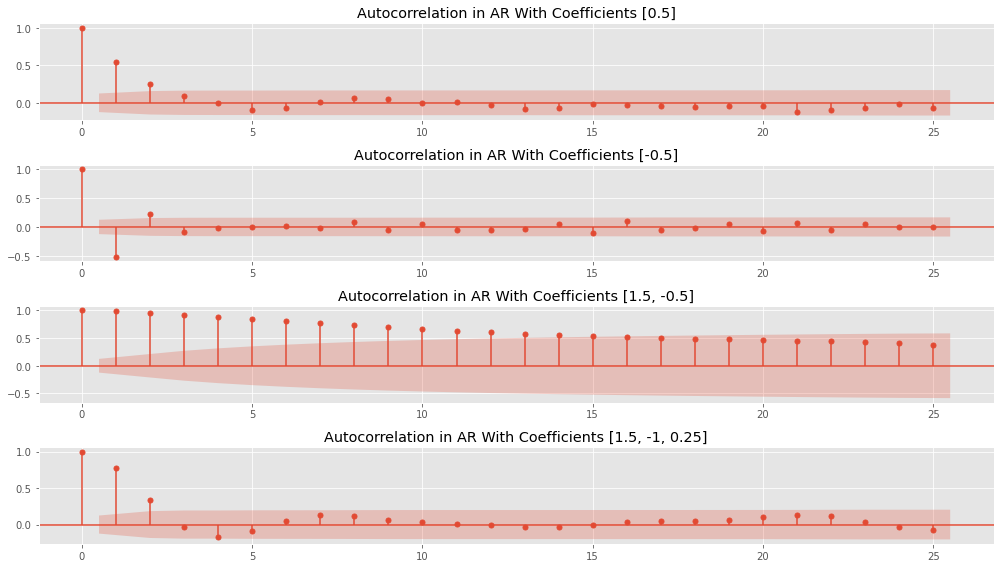

In [61]:
fig, axs = plt.subplots(4, figsize=(14, 8))

for i, (ax, coef) in enumerate(zip(axs, ar_coefs)):
    series = auto_regressive_process(size=250, coefs=coef)
    _ = sm.graphics.tsa.plot_acf(series, lags=25, ax=ax)
    ax.set_title("Autocorrelation in AR With Coefficients {}".format(str(list(coef))))
    
plt.tight_layout()

In an AR process, even though subsequent data points are only *directly* influenced by a few previous data points, the influence tends to linger for a long time.

We can see this lingering influence in:
  - The gradual decrease in autocorrelation when the initial coefficient is positive.
  - The sinusoidal behaviour when there is negative coefficients.

For AR processes, controlling for this lingering influence with a *partial* autocorrelation plot is important.

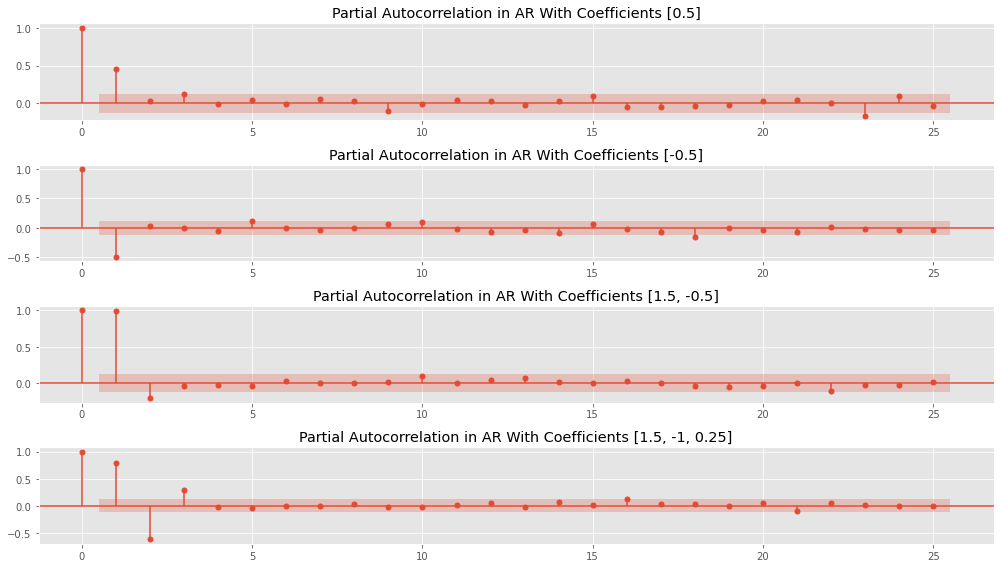

In [62]:
fig, axs = plt.subplots(4, figsize=(14, 8))

for i, (ax, coef) in enumerate(zip(axs, ar_coefs)):
    series = auto_regressive_process(size=250, coefs=coef)
    _ = sm.graphics.tsa.plot_pacf(series, lags=25, ax=ax, method='ywmle')
    ax.set_title("Partial Autocorrelation in AR With Coefficients {}".format(str(list(coef))))
    
plt.tight_layout()

In the partial autocorrelation plot, we see very distinctly that the number of significant spikes is directly influenced by the number of non-zero coefficients.

**Discussion:** What sort of a process would generate an autoregressive series?

### AR Models

Given stationary time series data, a reasonable question to ask is the following:
    
> Which AR series would be most likely to generate this data?

This is the concept behind AR models.

In [63]:
def fit_ar_model(series, order):
    # ARIMA is a more general model, which we are going to build up
    # in pieces.
    model = ARIMA(series, order=(order, 0, 0))
    return model.fit()

Let's generate some AR data, fit some AR models, then compare the coefficients.

In [64]:
for coef in ar_coefs:
    ar_series = auto_regressive_process(size=250, coefs=coef)
    ar_model = fit_ar_model(ar_series.values, order=(len(coef)))
    print("True Coefficients: {0: <26} Estimated Coefficients: {1: <26}".format(
            str(format_list_of_floats(coef)),
            str(format_list_of_floats(ar_model.params[1:]))))

True Coefficients: ['0.50']                   Estimated Coefficients: ['0.44', '1.18']          
True Coefficients: ['-0.50']                  Estimated Coefficients: ['-0.57', '1.10']         
True Coefficients: ['1.50', '-0.50']          Estimated Coefficients: ['1.54', '-0.54', '1.02'] 
True Coefficients: ['1.50', '-1.00', '0.25']  Estimated Coefficients: ['1.53', '-1.05', '0.28', '1.12']


Just like for MA models, it looks like out AR models recover the true coefficients from an AR process.

### ARMA Models

Now that we have discussed AR and MA models, we can *combine* them into ARMA models, which have both AR and MA components.

ARMA models have both:
  - A **linear combination of white noise** component (the MA), where subsequent values of the series are (partially) a linear combination of white noise.
  - An **autoregressive component** the (AR), where subsequent values of the series are (partially) a linear combination of previous terms, plus noise.

  
$$ y_i = \mu + \overbrace{e_i + a_1 e_{i-1} + \cdots + a_q e_{i-q}}^{\text{MA component}} + \overbrace{b_1 y_{i-1} + b_2 y_{i-2} + \cdots + b_p y_{i-p} + \epsilon_i}^{\text{AR component}} $$

where $a_1...a_q$ are the MA coefficients, $b_1...b_p$ are the AR coefficients, $e_i$ is a white-noise series, and $\epsilon_i$ is an error term.

### ARIMA Models

The **I** in ARIMA stands for **integrated**.

The word *integration* is used here as the opposite of *difference*.

**Recall:** We often have to take the *first difference* of series we find in nature to make them *stationary*.


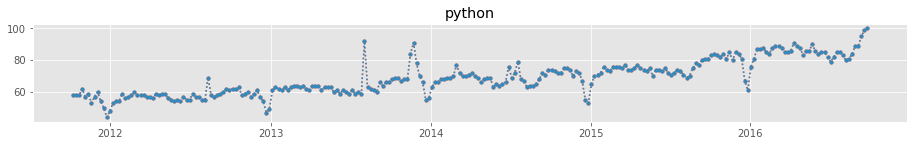

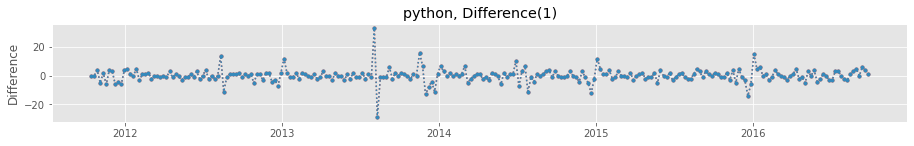

In [65]:
search_term = 'python'
series = google_trends[search_term]
plot_series_and_difference(series)

MA and AR (and, consequently ARMA) models *only apply to* stationary series.

So to model series in nature, we often have to model the *differenced* series as an ARMA process.

This leads us, finally, to **ARIMA**.

An **ARIMA(p, d, q)** model:
  - Applies an ARMA model to a series that has been differenced $d$ times.
  - The AR part of the ARMA model has order $p$.
  - The MA part of the ARMA model has order $q$.

Let's explore generating some data as an ARIMA process.

In [66]:
def arima_process(size, ar_coefs, ma_coefs, d=0):
    """Simulate a series from an arima model."""
    arma = ArmaProcess(ar_coefs, ma_coefs)
    arma_series = arma.generate_sample(size + d)
    # Integrate d times.
    for i in range(d):
        arma_series = np.cumsum(arma_series)
    return pd.Series(arma_series)

def plot_arima_process(ax, size, ar_coefs, ma_coefs, d=0):
    series = arima_process(size, ar_coefs, ma_coefs, d)
    ax.plot(series.index, series)

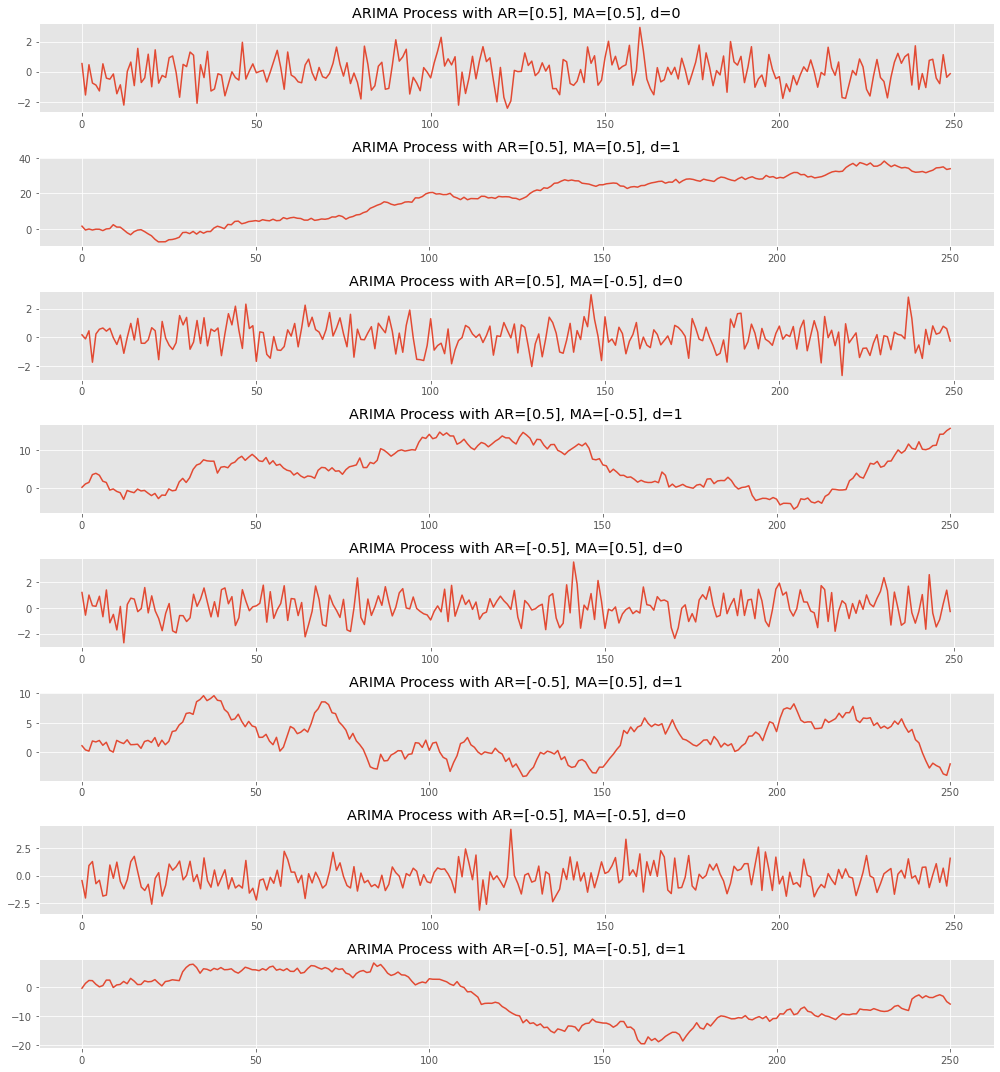

In [67]:
ar_coefs = [[0.5], [-0.5]]
ma_coefs = [[0.5], [-0.5]]
ds = [0, 1]

fig, axs = plt.subplots(8, figsize=(14, 15))

for ax, (ar, ma, d) in zip(axs, itertools.product(ar_coefs, ma_coefs, ds)):
    plot_arima_process(ax, 250, ar, ma, d)
    ax.set_title("ARIMA Process with AR={}, MA={}, d={}".format(
        str(list(ar)), str(list(ma)), d))
    
plt.tight_layout()

And, one final time, fitting an ARIMA model recovers the coefficients of a simulated ARIMA process.

### Case Study:  Electrical Equipment Orders Data

Let's attempt to fit an ARIMA model to a series of electrical orders, and use it to forecast future values.

In [68]:
file_name = os.path.join('.', 'data', 'elec-equip.csv')
df = pd.read_csv(file_name)
electric_series = pd.Series(df['x'].values, 
                            pd.date_range(start='01-1996', end='12-2011', freq='M'), name='elec-equip')

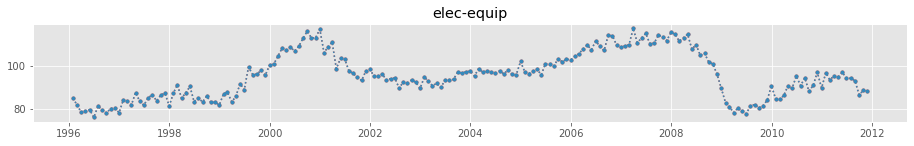

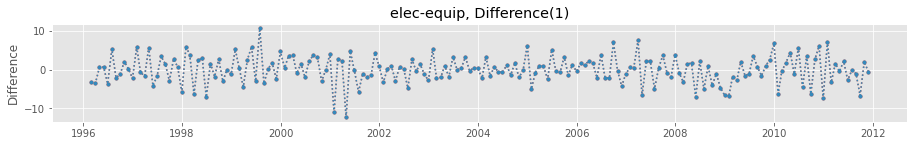

In [69]:
series = electric_series
plot_series_and_difference(series)

The original series is clearly **nonstationary**, so we differenced it.  The resulting series looks stationary, but let's use a test to check.

In [70]:
electric_differences = electric_series.diff()[1:]
test = sm.tsa.stattools.kpss(electric_differences, nlags='auto')
print("KPSS p-value for differenced electric series: {0:2.2f}".format(test[1]))

KPSS p-value for differenced electric series: 0.10


C:\Users\K\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1876: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(warn_msg.format(direction="greater"), InterpolationWarning)


So the differenced series is stationary, and we can attempt to model it as an ARMA process.

We need to determine the correct order for the AR and MA models, so let's look at the auto and partial auto correlation plots.

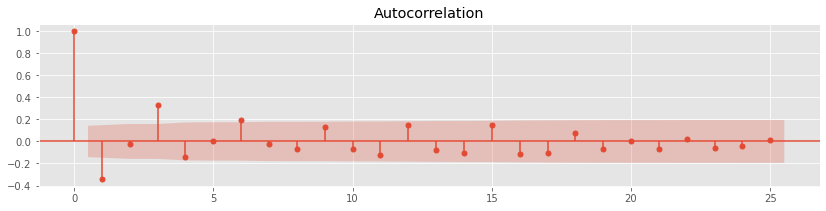

In [71]:
fig, ax = plt.subplots(1, figsize=(14, 3))
_ = sm.graphics.tsa.plot_acf(electric_differences, lags=25, ax=ax)

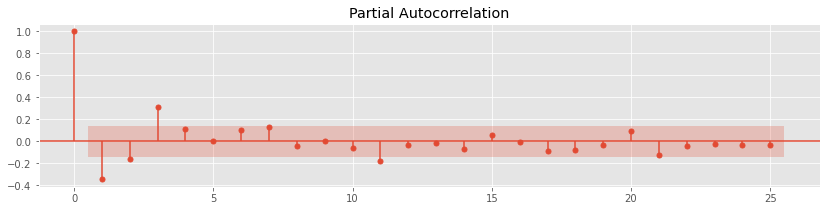

In [72]:
fig, ax = plt.subplots(1, figsize=(14, 3))
_ = sm.graphics.tsa.plot_pacf(electric_differences, lags=25, ax=ax)

We see the following evidence:
  - Oscillatory behavior in the autocorrelation plot.
  - Three significant partial autocorrelations at the beginning of the plot.
  
This suggests that the differenced series may be well modeled as an $AR(3)$ series.

Since we applied *one* difference to achieve seasonality, this suggests that we should model the *original* series as an $ARIMA(3, 1, 0)$.

In [73]:
from statsmodels.tsa.arima_model import ARIMA as ARIMA_deprecated
electric_model = ARIMA_deprecated(electric_series, order=(3, 1, 0)).fit()

print("ARIMA(3, 1, 0) coefficients from Electric model:\n  Intercept {0:2.2f}\n  AR {1}".format(
    electric_model.params[0], 
        format_list_of_floats(list(electric_model.params[1:]))
    ))

ARIMA(3, 1, 0) coefficients from Electric model:
  Intercept 0.01
  AR ['-0.35', '-0.04', '0.31']


C:\Users\K\miniconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


Let's simulate some data using these coefficients and see if it looks like our differenced data.

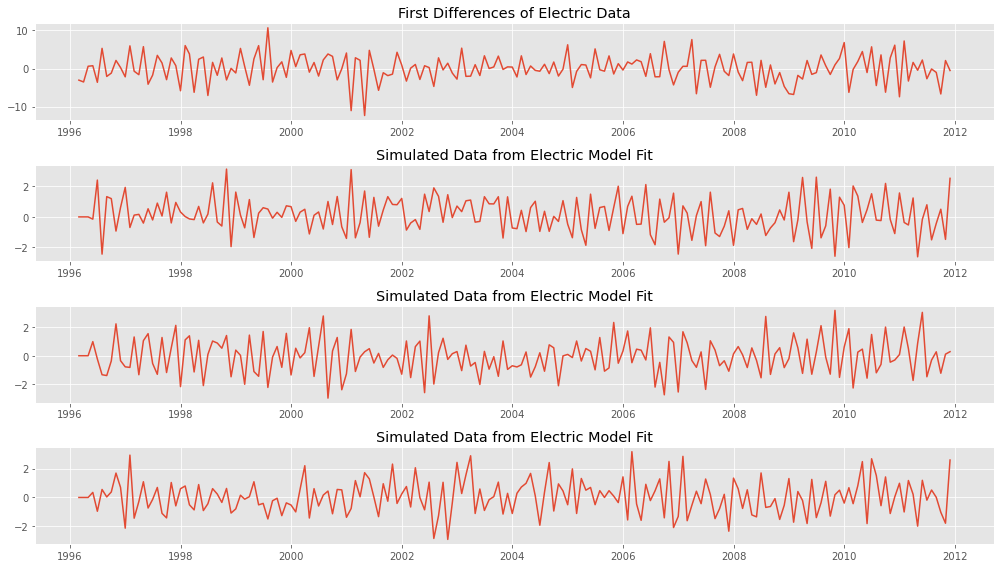

In [74]:
fig, ax = plt.subplots(4, figsize=(14, 8))

ax[0].plot(electric_differences.index, electric_differences)
ax[0].set_title("First Differences of Electric Data")

for i in range(1, 4):
    simulated_data = auto_regressive_process(len(electric_differences), 
                                             list(electric_model.params)[1:])
    simulated_data.index = electric_differences.index
    ax[i].plot(simulated_data.index, simulated_data)
    ax[i].set_title("Simulated Data from Electric Model Fit")
    
plt.tight_layout()

We can also use the fit model to project electric sales into the future.

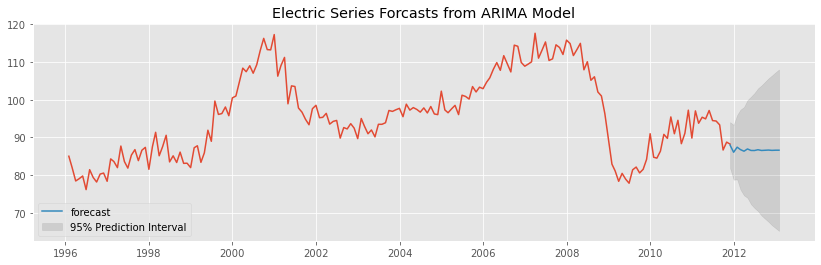

In [75]:
electric_model = ARIMA(electric_series, order=(3, 1, 0)).fit()
electric_series.reindex(pd.date_range(start='01-1996', end='12-2012', freq='M'))

fig, ax = plt.subplots(1, figsize=(14, 4))
ax.plot(electric_series.index, electric_series)
res = electric_model.get_prediction('2011-11-30', '2013', 
                                  dynamic=True, ax=ax, plot_insample=False)
preds = res.predicted_mean
ci = res.conf_int()
ax.plot(preds, label='forecast')
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='k', alpha=0.1, label='95% Prediction Interval')

ax.legend(loc="lower left")

ax.set_title("Electric Series Forcasts from ARIMA Model");

Zooming in, we can see that we **have** done a bit better than the naive forecast of predicting the last observed value.

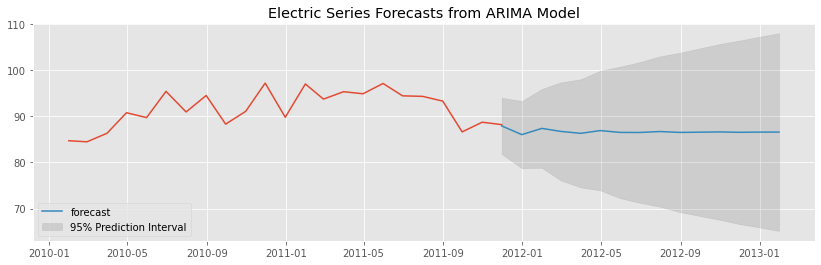

In [76]:
electric_series.reindex(pd.date_range(start='01-1996', end='12-2012', freq='M'))

fig, ax = plt.subplots(1, figsize=(14, 4))
ax.plot(electric_series['2010':].index, electric_series['2010':])
res = electric_model.get_prediction('2011-11-30', '2013', 
                                  dynamic=True, ax=ax, plot_insample=False)
preds = res.predicted_mean
ci = res.conf_int()
ax.plot(preds, label='forecast')
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='k', alpha=0.1, label='95% Prediction Interval')

ax.legend(loc="lower left")

ax.set_title("Electric Series Forecasts from ARIMA Model");

If our model is good, the residuals should have no patterns whatsoever, i.e., be *white noise*

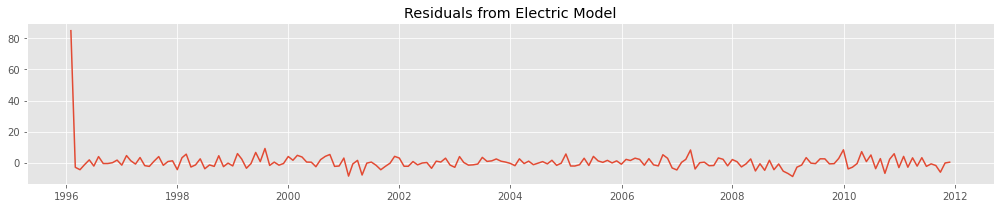

In [77]:
fig, ax = plt.subplots(1, figsize=(14, 3))
ax.plot(electric_model.resid.index, electric_model.resid)
ax.set_title("Residuals from Electric Model")
plt.tight_layout()

One way to diagnose this is to check if any autocorrelation remains in the residuals.

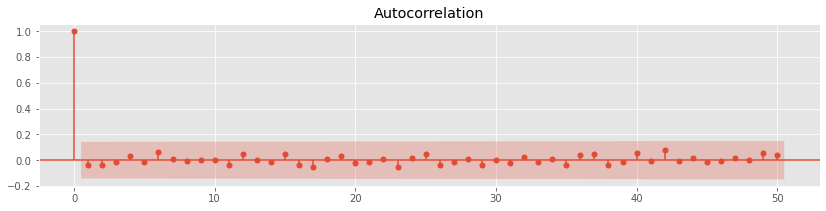

In [78]:
fig, ax = plt.subplots(1, figsize=(14, 3))
_ = sm.graphics.tsa.plot_acf(electric_model.resid, lags=50, ax=ax)

All the autocorrelations are within the confidence bands, so it looks like our model fits the data well.

In [79]:
# ARIMA(3, 1, 0)
electric_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             elec-equip   No. Observations:                  191
Model:                 ARIMA(3, 1, 0)   Log Likelihood                -485.666
Date:                Tue, 10 Nov 2020   AIC                            979.331
Time:                        14:14:28   BIC                            992.319
Sample:                    01-31-1996   HQIC                           984.593
                         - 11-30-2011                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3488      0.068     -5.167      0.000      -0.481      -0.216
ar.L2         -0.0386      0.074     -0.520      0.603      -0.184       0.107
ar.L3          0.3139      0.064      4.906      0.000       0.188       0.439
sigma2         9.6969      0.976      9.936      0.000       7.784      11.610
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):                 1.49
Prob(Q):                              0.63   Prob(JB):                         0.48
Heteroskedasticity (H):               1.22   Skew:                             0.05
Prob(H) (two-sided):                  0.43   Kurtosis:                         3.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Model Selection: AIC

We made our selection of model based on the autocorrelation and partial autocorrelation plot, which is a good first step.

The overall procedure we followed is called the **Box-Jenkins Method**.

Hyndmann recommends also trying a few models that are "close by", varying the ARMA parameters slightly, and then selecting the best model from the results using an information criteria.

In [80]:
parameters = [
    {'AR': 3, 'MA': 0},
    {'AR': 2, 'MA': 0},
    {'AR': 4, 'MA': 0},
    {'AR': 3, 'MA': 1}
]

models = {}
for params in parameters:
    models[(params['AR'], params['MA'])] = ARIMA(electric_series, 
                                                 order=(params['AR'],
                                                        1, 
                                                        params['MA'])).fit()
    
for model_params in models:
    print("ARIMA({}, 1, {}) AIC: {}".format(model_params[0], 
                                            model_params[1], 
                                            models[model_params].aic))

ARIMA(3, 1, 0) AIC: 979.331234609989
ARIMA(2, 1, 0) AIC: 996.6791785061293
ARIMA(4, 1, 0) AIC: 978.9045832895886
ARIMA(3, 1, 1) AIC: 978.1661643242318


The $ARIMA(3, 1, 1)$ model has a *slightly* better AIC, so following Hyndmann, we would select this as our final model.

The overall methodology for producing an ARIMA model is summarized in the following flowchart, taken from Hyndmann.

![Hyndmann Modeling Process](images/hyndman-modeling-process.png)

## Case Study: Baseball Searches

Let's complete our day with one more case study, the baseball search series we have been referencing the entire day.

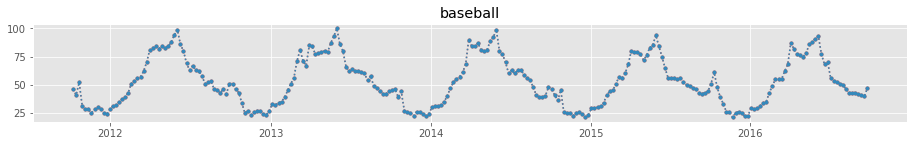

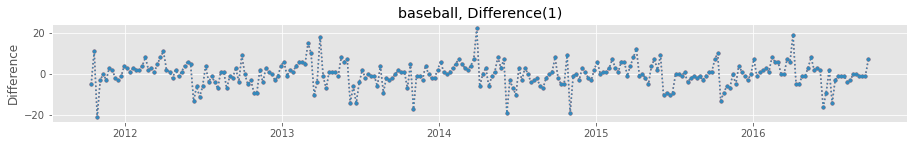

In [81]:
search_term = 'baseball'
series = google_trends[search_term]
plot_series_and_difference(series)

Recall that the differenced series **was** found to be stationary, but the partial autocorrelation plot had a curious feature.

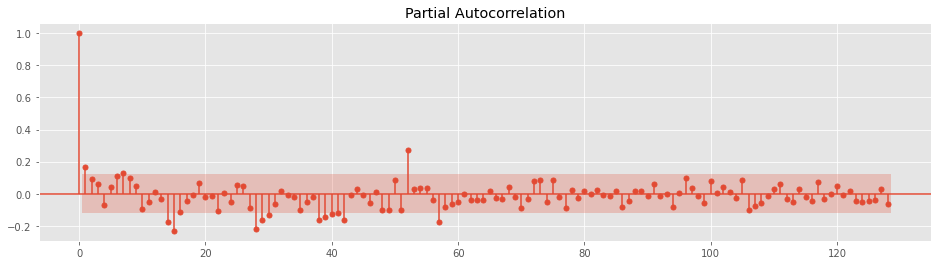

In [82]:
fig, ax = plt.subplots(1, figsize=(16, 4))

sm.graphics.tsa.plot_pacf(baseball_diff, lags=128, ax=ax, method='ywmle');

That spike at $52$ weeks is something we don't know how to deal with yet!

There is a generalization of ARIMA that handles seasonality, which is included in the (development) version of `statsmodels` as SARIMAX.  The seasonal ARIMA model fits sub-ARIMA models to each seasonal sequence of data.

A seasonal ARIMA model has more parameters

$$ SARIMA(p, d, q)(sp, sd, sq)_k$$

The $p$, $d$, and $q$ indices mean exactly the same thing as before.

The $k$ is the length of a season, i.e., the observation window that exhibits periodic behavior.

In our example we observe the following:
  - The seasonal behavior in the partial autocorrelation plot happens at $52$ weeks.
  - There is only *one* significant seasonal partial autocorrelation.
  - There is only *one* significant initial partial autocorrelation.

Altogether, this means that an appropriate model would be a

$$ SARIMA(1, 1, 0)(1, 0, 0)_{52} $$

In [83]:
baseball_series = google_trends['baseball']

baseball_model = SARIMAX(baseball_series, 
                         order=(1, 1, 0), 
                         seasonal_order=(1, 0, 0, 52)).fit()

C:\Users\K\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  warnings.warn('No frequency information was'
C:\Users\K\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  warnings.warn('No frequency information was'


Let's check the residuals for white noise'ness

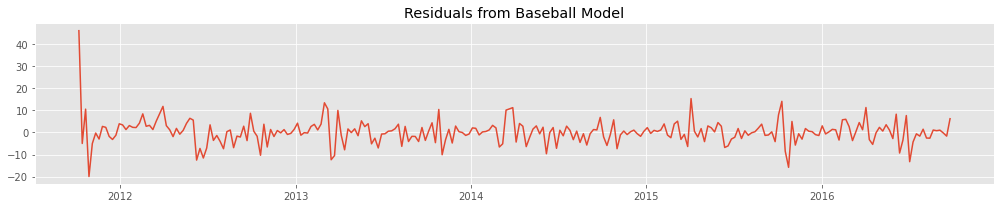

In [84]:
fig, ax = plt.subplots(1, figsize=(14, 3))
ax.plot(baseball_model.resid.index, baseball_model.resid)
ax.set_title("Residuals from Baseball Model")
plt.tight_layout()

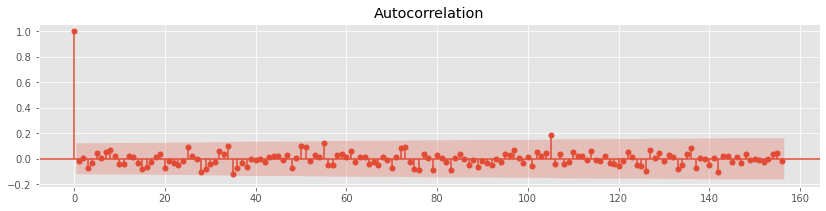

In [85]:
fig, ax = plt.subplots(1, figsize=(14, 3))
_ = sm.graphics.tsa.plot_acf(baseball_model.resid, lags=3*52, ax=ax)

There is one significant autocorrelation, but we expect at least a couple due to random chance, so this is satisfying.

To wrap up, let's see how the forecasts look.

In [86]:
# Pandas is a bit fussy about reindexing here, we need to extend the dates but
# Pandas's weekly series does not align with google's.
baseball_series.index = pd.date_range(start='10-7-2011',
                                      end='9-25-2016', freq='W')
baseball_series = baseball_series.reindex(pd.date_range(
        start='10-7-2011', end='2020', freq='W'))

results = baseball_model.get_prediction('2016-09', '2020', 
                   dynamic=True, ax=ax, plot_insample=False)

preds = results.predicted_mean
ci = results.conf_int()

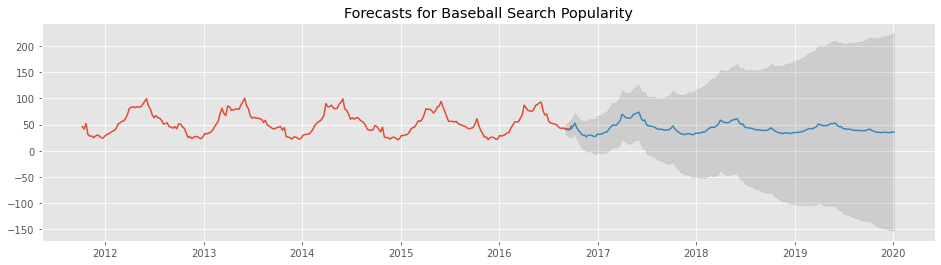

In [87]:
fig, ax = plt.subplots(1, figsize=(16, 4))

ax.plot(baseball_series.index, baseball_series)

ax.plot(preds.index, preds)
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='k', alpha=0.1)
ax.set_title("Forecasts for Baseball Search Popularity");

In [88]:
# SARIMAX(1, 1, 0)x(1, 0, 0, 52)
baseball_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                           baseball   No. Observations:                  260
Model:             SARIMAX(1, 1, 0)x(1, 0, 0, 52)   Log Likelihood                -777.532
Date:                            Tue, 10 Nov 2020   AIC                           1561.063
Time:                                    14:14:31   BIC                           1571.734
Sample:                                10-08-2011   HQIC                          1565.354
                                     - 09-24-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0960      0.043     -2.233      0.026      -0.180      -0.012
ar.S.L52       0.6514      0.035     18.651      0.000       0.583       0.720
sigma2        21.2283      1.406     15.094      0.000      18.472      23.985
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                27.20
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               1.01   Skew:                            -0.06
Prob(H) (two-sided):                  0.96   Kurtosis:                         4.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<details>
    <summary>Version History</summary>
------------------------------------------------------------------------
<!-- 72 characters long -->
    
    v1.2
    - helper class created.
    - First half of notebook revised (until ARIMA models.)
        - Definitions checked and revised against textbooks.
        - Order of detrending and deseasonalizing example added.
        - Code refactored.
        - ADF test replaced by KPSS test.
    - Deprecated code updated for second half of notebook.
    - Version history added.

    Kin-Yip Chien (Nov 9, 2020)
    
    v1.1
    - Weather example added.
    - Box-Cox transformation example added.
    - Discussion questions added.
    
    Frank Burkholder, Dan Rupp
    
    v1
    - Notebook created.
    
    Matt Drury
</details>